# **Laboratorium 5** - Manipulacja danymi przy użyciu **Pandas**

## 4.1 Zepsucie datasetu

In [1257]:
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub as kg
from kagglehub import KaggleDatasetAdapter
import numpy as np

Załadowanie datasetu do ramki danych

In [1258]:
data_set_path = "insurance.csv"
df = kg.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "mirichoi0218/insurance",
    data_set_path
)
df.describe(include='all')

age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1338.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    13270.422265  
std     12110.011237  
min      1121.873900  
25%      4740.287150  
50%      9382.033000  
75%     16639.912515  
max     63770.428010

Macierz korelacji

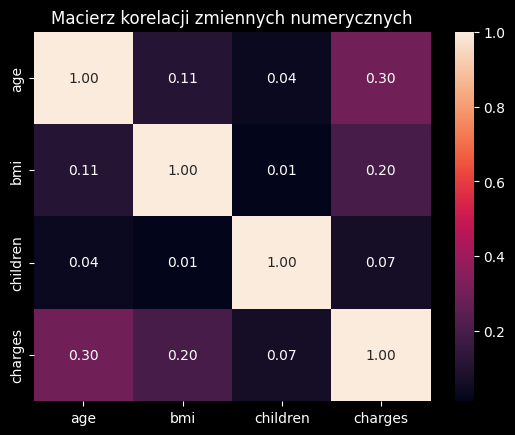

In [1259]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['str']).columns.tolist()
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Macierz korelacji zmiennych numerycznych")
plt.show()

Przed rozpoczęciem poprawnego należy przygotować dane z typowymi błędami spotykanymi w datasetach.

In [1260]:
import pandas as pd
import numpy as np
import random

def psuj_dataset(df: pd.DataFrame) -> pd.DataFrame:
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    df_zepsuty = df.copy()

    mask_mcar = np.random.random(len(df_zepsuty)) < 0.10
    df_zepsuty.loc[mask_mcar, 'bmi'] = np.nan

    mask_mar = (df_zepsuty['smoker']=='yes') & (np.random.random(len(df_zepsuty)) < 0.20)
    df_zepsuty.loc[mask_mar, 'age'] = np.nan

    threshold = df_zepsuty['charges'].quantile(0.85)
    mask_mnar = (df_zepsuty['charges'] > threshold) & (np.random.random(len(df_zepsuty)) < 0.40)
    df_zepsuty.loc[mask_mnar, 'charges'] = np.nan

    df_zepsuty['referral_code'] = pd.Series([np.nan] * len(df_zepsuty), dtype=object)
    mask_trash = np.random.random(len(df_zepsuty)) < 0.35
    df_zepsuty.loc[mask_trash, 'referral_code'] = "REF123"

    n_duplicates = int(len(df_zepsuty) * 0.08)  # 8% duplikatów
    if n_duplicates > 0:
        duplicate_indices = np.random.choice(df_zepsuty.index, size=n_duplicates, replace=True)
        df_duplicates = df_zepsuty.loc[duplicate_indices].copy()
        df_zepsuty = pd.concat([df_zepsuty, df_duplicates], ignore_index=True)

    outlier_indices = np.random.choice(df_zepsuty.index, size=20, replace=False)
    df_zepsuty.loc[outlier_indices, 'bmi'] = df_zepsuty['bmi'].mean() + 10 * df_zepsuty['bmi'].std()

    niespojnosc_indices = np.random.choice(df_zepsuty.index, size=100, replace=False)
    for idx in niespojnosc_indices:
        val = str(df_zepsuty.loc[idx, 'region'])
        problem = random.choice(['lowercase', 'uppercase', 'whitespace'])
        if problem == 'lowercase': df_zepsuty.loc[idx, 'region'] = val.lower()
        elif problem == 'uppercase': df_zepsuty.loc[idx, 'region'] = val.upper()
        elif problem == 'whitespace': df_zepsuty.loc[idx, 'region'] = f"  {val}  "

    nonsense_indices = np.random.choice(df_zepsuty.index, size=15, replace=False)
    df_zepsuty.loc[nonsense_indices, 'age'] = -5

    df_zepsuty['age_total_months'] = df_zepsuty['age'] * 12 + np.random.normal(0, 1, len(df_zepsuty))


    df_zepsuty = df_zepsuty.sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_zepsuty

In [1261]:
df_zepsuty = psuj_dataset(df)
df_zepsuty

age     sex     bmi  children smoker     region      charges  \
0     25.0    male  23.900         5     no  southwest   5080.09600   
1     50.0    male  32.205         0     no  northwest   8835.26495   
2     61.0    male     NaN         0     no  northwest  12950.07120   
3     19.0  female  28.900         0     no  southwest   1743.21400   
4     47.0  female  45.320         1     no  southeast   8569.86180   
...    ...     ...     ...       ...    ...        ...          ...   
1440  18.0  female  31.350         4     no  northeast   4561.18850   
1441  39.0  female  23.870         5     no  southeast   8582.30230   
1442  58.0    male  25.175         0     no  northeast  11931.12525   
1443  37.0  female  47.600         2    yes  southwest          NaN   
1444  55.0    male     NaN         0     no  southwest  10214.63600   

     referral_code  age_total_months  
0           REF123        301.700135  
1           REF123        600.175245  
2           REF123        730.736119  
3           REF123        229.209494  
4              NaN        564.646449  
...            ...               ...  
1440           NaN        215.443903  
1441           NaN        467.139453  
1442           NaN        698.323267  
1443        REF123        442.477285  
1444           NaN        660.023469  

[1445 rows x 9 columns]

In [1262]:
df_zepsuty.describe(include='all')

age   sex          bmi     children smoker     region  \
count   1387.000000  1445  1287.000000  1445.000000   1445       1445   
unique          NaN     2          NaN          NaN      2         12   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   732          NaN          NaN   1155        374   
mean      38.675559   NaN    31.437003     1.089965    NaN        NaN   
std       14.780501   NaN     9.548814     1.202578    NaN        NaN   
min       -5.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       26.000000   NaN    26.190000     0.000000    NaN        NaN   
50%       39.000000   NaN    30.305000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.770000     2.000000    NaN        NaN   
max       64.000000   NaN    90.772613     5.000000    NaN        NaN   

             charges referral_code  age_total_months  
count    1357.000000           516       1387.000000  
unique           NaN             1               NaN  
top              NaN        REF123               NaN  
freq             NaN           516               NaN  
mean    11477.406350           NaN        464.093954  
std     10234.047008           NaN        177.362798  
min      1121.873900           NaN        -60.808023  
25%      4518.826250           NaN        311.656846  
50%      8615.300000           NaN        467.526878  
75%     13822.803000           NaN        612.603096  
max     63770.428010           NaN        769.574949

Raportowanie ilościowe (Tabela braków)

In [1263]:
missing_values = df_zepsuty.isnull().sum()
missing_percent = (missing_values / len(df_zepsuty)) * 100

missing_report = pd.DataFrame({
    'Kolumna': missing_values.index,
    'Liczba braków': missing_values.values,
    'Procent braków [%]': missing_percent.values
}).sort_values(by='Procent braków [%]', ascending=False)

missing_report

Kolumna  Liczba braków  Procent braków [%]
7     referral_code            929           64.290657
2               bmi            158           10.934256
6           charges             88            6.089965
0               age             58            4.013841
8  age_total_months             58            4.013841
1               sex              0            0.000000
3          children              0            0.000000
4            smoker              0            0.000000
5            region              0            0.000000

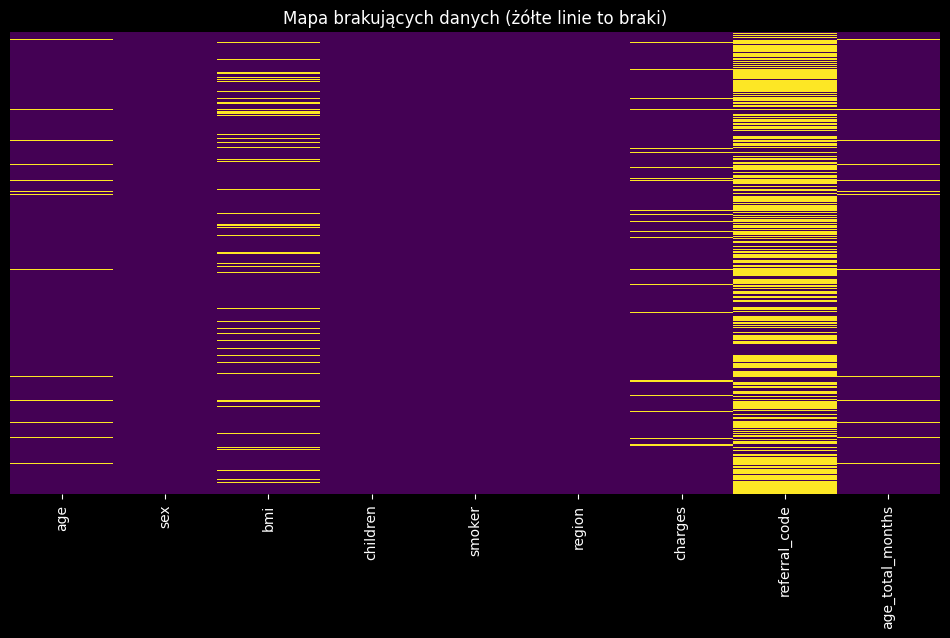

In [1264]:
import seaborn as sns
import matplotlib.pyplot as plt

#df_sorted = df_zepsuty.sort_values(by=['smoker', 'charges'])
plt.figure(figsize=(12, 6))
sns.heatmap(df_zepsuty.isnull(), yticklabels=False, cbar=False, cmap='viridis')
#sns.heatmap(df_sorted.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Mapa brakujących danych (żółte linie to braki)')
plt.show()

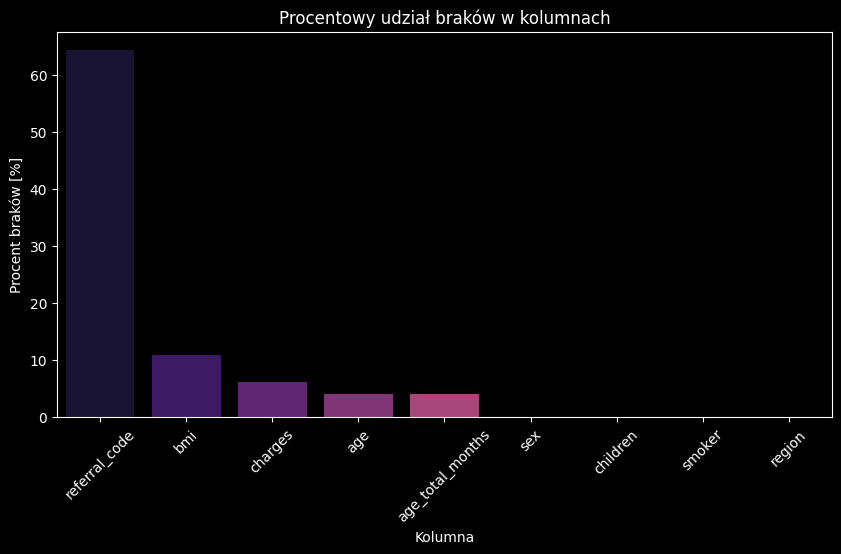

In [1265]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Kolumna', y='Procent braków [%]', data=missing_report,hue='Kolumna', palette='magma',legend=False)
plt.xticks(rotation=45)
plt.title('Procentowy udział braków w kolumnach')
plt.show()

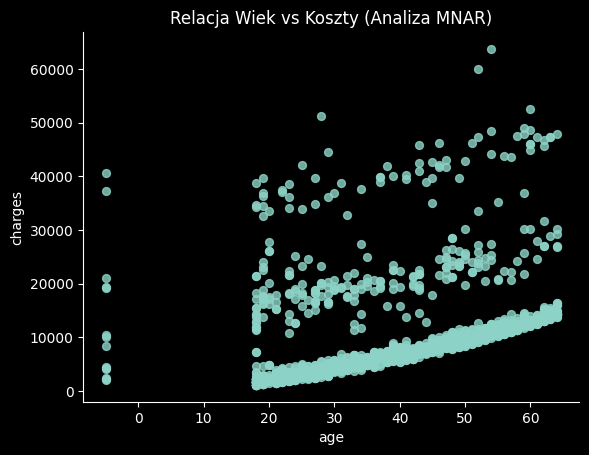

In [1266]:
from matplotlib import pyplot as plt
df_zepsuty.plot(kind='scatter', x='age', y='charges', s=32, alpha=.8)
plt.title('Relacja Wiek vs Koszty (Analiza MNAR)')
plt.gca().spines[['top', 'right',]].set_visible(False)


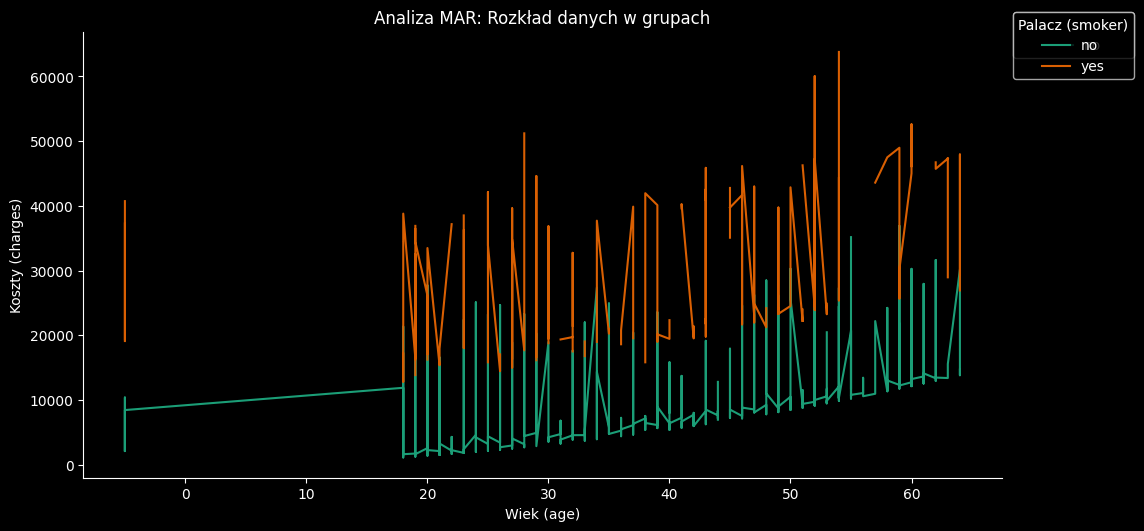

In [1267]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  series = series.sort_values('age')
  xs = series['age']
  ys = series['charges']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
#df_sorted = df_zepsuty.sort_values('commute_time', ascending=True)
for i, (series_name, series) in enumerate(df_zepsuty.groupby('smoker')):
  _plot_series(series, series_name, i)
  fig.legend(title='Palacz (smoker)', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Wiek (age)')
plt.ylabel('Koszty (charges)')
plt.title('Analiza MAR: Rozkład danych w grupach')
plt.show()


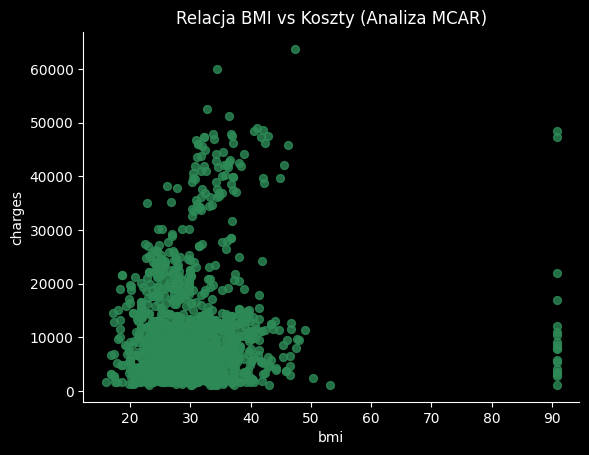

In [1268]:
from matplotlib import pyplot as plt
df_zepsuty.plot(kind='scatter', x='bmi', y='charges', s=32, alpha=.8, color='seagreen')
plt.title('Relacja BMI vs Koszty (Analiza MCAR)')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


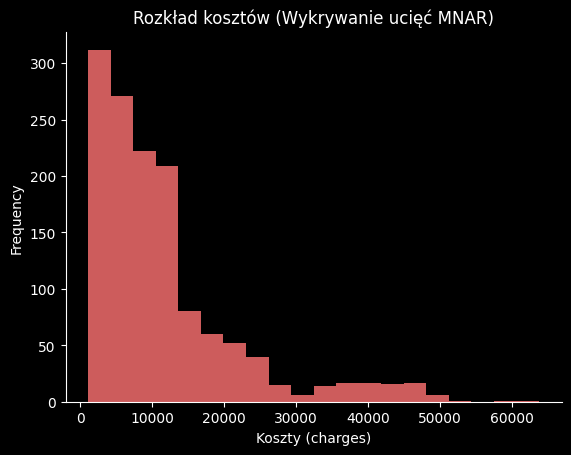

In [1269]:
df_zepsuty['charges'].plot(kind='hist', bins=20, title='Rozkład kosztów (Wykrywanie ucięć MNAR)', color='indianred')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Koszty (charges)')
plt.show()

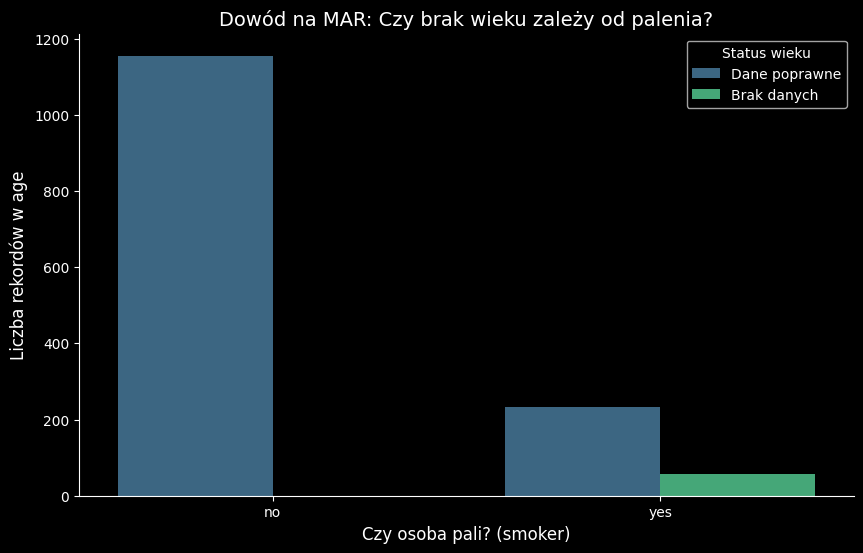

In [1270]:
import seaborn as sns
import matplotlib.pyplot as plt

df_zepsuty_cbw = df_zepsuty.copy()
df_zepsuty_cbw['czy_brak_wieku'] = df_zepsuty['age'].isnull().map({True: 'Brak danych', False: 'Dane poprawne'})

plt.figure(figsize=(10, 6))
sns.countplot(data=df_zepsuty_cbw, x='smoker', hue='czy_brak_wieku', palette='viridis')

plt.title('Dowód na MAR: Czy brak wieku zależy od palenia?', fontsize=14)
plt.xlabel('Czy osoba pali? (smoker)', fontsize=12)
plt.ylabel('Liczba rekordów w age', fontsize=12)
plt.legend(title='Status wieku')
sns.despine()
plt.show()

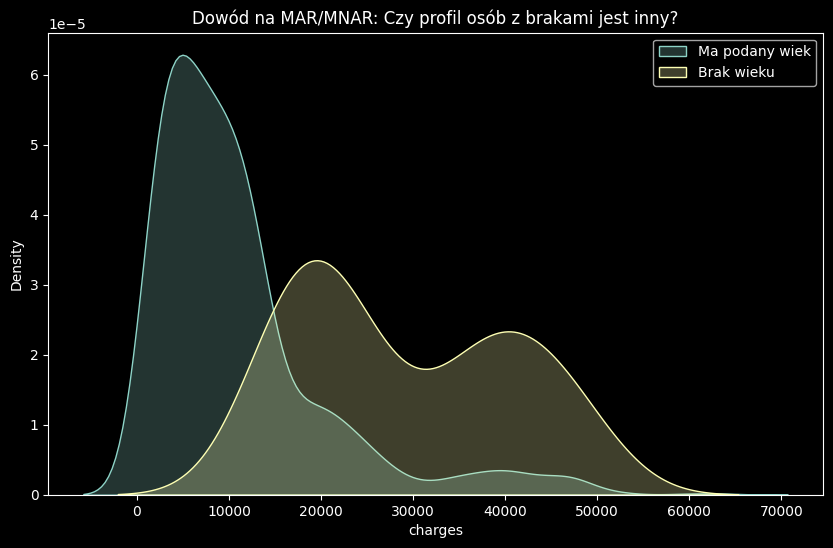

In [1271]:
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df_zepsuty[df_zepsuty['age'].notnull()], x='charges', label='Ma podany wiek', fill=True)
sns.kdeplot(data=df_zepsuty[df_zepsuty['age'].isnull()], x='charges', label='Brak wieku', fill=True)
plt.title('Dowód na MAR/MNAR: Czy profil osób z brakami jest inny?')
plt.legend()
plt.show()

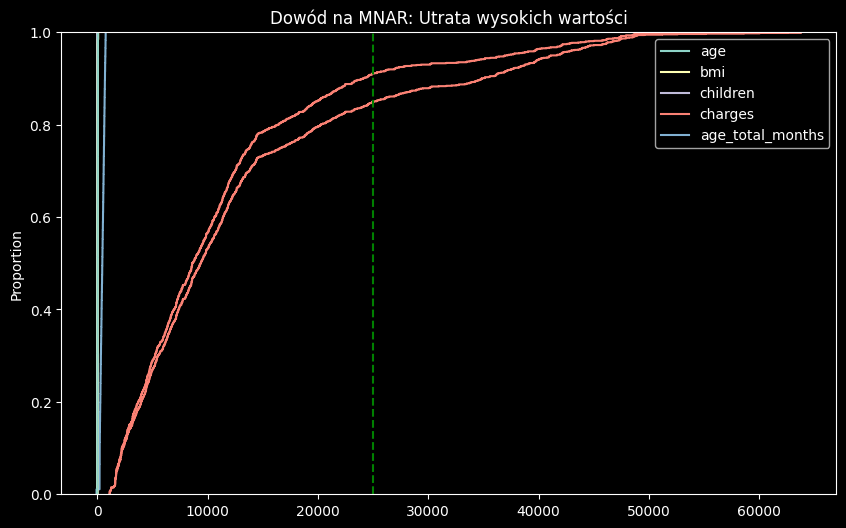

In [1272]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, label='Oryginalne dane (df)', color='blue')
sns.ecdfplot(data=df_zepsuty, label='Dane zepsute (df_zepsuty)', color='red')
plt.title('Dowód na MNAR: Utrata wysokich wartości')
plt.axvline(df['charges'].quantile(0.85), color='green', linestyle='--', label='Próg ucięcia MNAR')
plt.show()

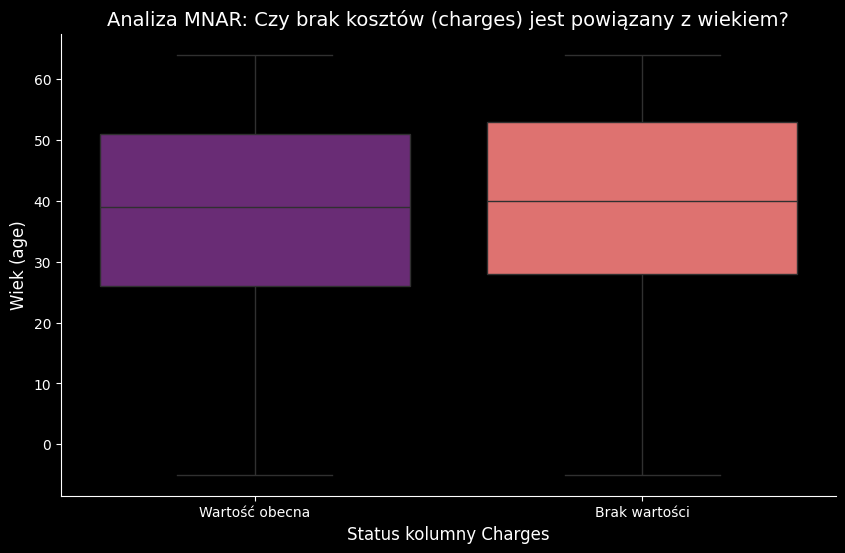

In [1273]:
df_zepsuty_cbc = df_zepsuty.copy()
df_zepsuty_cbc['czy_brak_charges'] = df_zepsuty['charges'].isnull().map({True: 'Brak wartości', False: 'Wartość obecna'})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_zepsuty_cbc, x='czy_brak_charges', y='age', hue='czy_brak_charges', palette='magma')

plt.title('Analiza MNAR: Czy brak kosztów (charges) jest powiązany z wiekiem?', fontsize=14)
plt.xlabel('Status kolumny Charges', fontsize=12)
plt.ylabel('Wiek (age)', fontsize=12)
sns.despine()
plt.show()

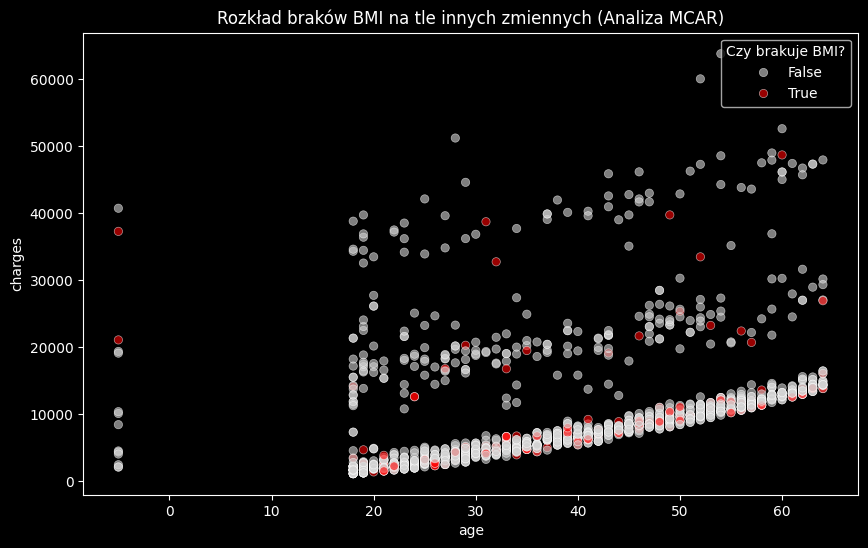

In [1274]:
df_zepsuty_bmim = df_zepsuty.copy()
df_zepsuty_bmim['bmi_missing'] = df_zepsuty['bmi'].isnull()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_zepsuty_bmim, x='age', y='charges', hue='bmi_missing', alpha=0.6, palette={True: 'red', False: 'lightgrey'})
plt.title('Rozkład braków BMI na tle innych zmiennych (Analiza MCAR)')
plt.legend(title='Czy brakuje BMI?')
plt.show()

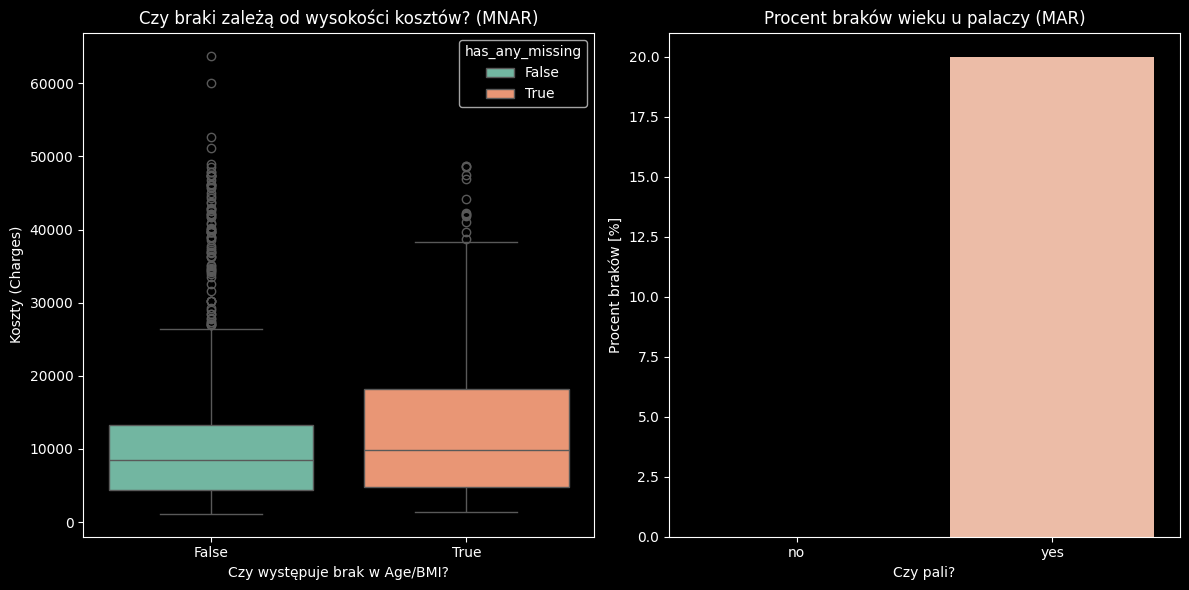

In [1275]:
import matplotlib.pyplot as plt
import seaborn as sns

df_zepsuty_ham = df_zepsuty.copy()
df_zepsuty_ham['has_any_missing'] = df_zepsuty[['age', 'bmi']].isnull().any(axis=1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_zepsuty_ham, x='has_any_missing', y='charges', hue='has_any_missing', palette='Set2')
plt.title('Czy braki zależą od wysokości kosztów? (MNAR)')
plt.xlabel('Czy występuje brak w Age/BMI?')
plt.ylabel('Koszty (Charges)')

plt.subplot(1, 2, 2)

missing_by_smoker = df_zepsuty_ham.groupby('smoker')['age'].apply(lambda x: x.isnull().mean() * 100)
sns.barplot(x=missing_by_smoker.index, y=missing_by_smoker.values, hue=missing_by_smoker.index, palette='coolwarm')
plt.title('Procent braków wieku u palaczy (MAR)')
plt.ylabel('Procent braków [%]')
plt.xlabel('Czy pali?')

plt.tight_layout()
plt.show()


Duplikaty

In [1276]:
liczba_duplikatow = df_zepsuty.duplicated().sum()

liczba_unikalnych = len(df_zepsuty) - liczba_duplikatow

procent_duplikatow = (liczba_duplikatow / len(df_zepsuty)) * 100

print(f"Liczba wszystkich wierszy: {len(df_zepsuty)}")
print(f"Liczba duplikatów: {liczba_duplikatow}")
print(f"Stosunek procentowy duplikatów: {procent_duplikatow:.2f}%")

Liczba wszystkich wierszy: 1445
Liczba duplikatów: 3
Stosunek procentowy duplikatów: 0.21%


In [1277]:
# Sprawdzamy duplikaty biorąc pod uwagę tylko kluczowe cechy pacjenta
kolumny_pacjenta = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
duplikaty_logiczne = df_zepsuty.duplicated(subset=kolumny_pacjenta).sum()

liczba_unikalnych = len(df_zepsuty) - duplikaty_logiczne

procent_duplikatow = (duplikaty_logiczne / len(df)) * 100
procent_duplikatow_zr = ((len(df_zepsuty)-len(df)) / len(df)) * 100

print(f"Liczba duplikatów (całe wiersze): {df_zepsuty.duplicated().sum()}")
print(f"Liczba duplikatów (tylko cechy pacjenta): {duplikaty_logiczne}")
print(f"Stosunek procentowy duplikatów: {procent_duplikatow:.2f}%")
print(f"Stosunek procentowy duplikatów: {procent_duplikatow_zr:.2f}%")

Liczba duplikatów (całe wiersze): 3
Liczba duplikatów (tylko cechy pacjenta): 93
Stosunek procentowy duplikatów: 6.95%
Stosunek procentowy duplikatów: 8.00%


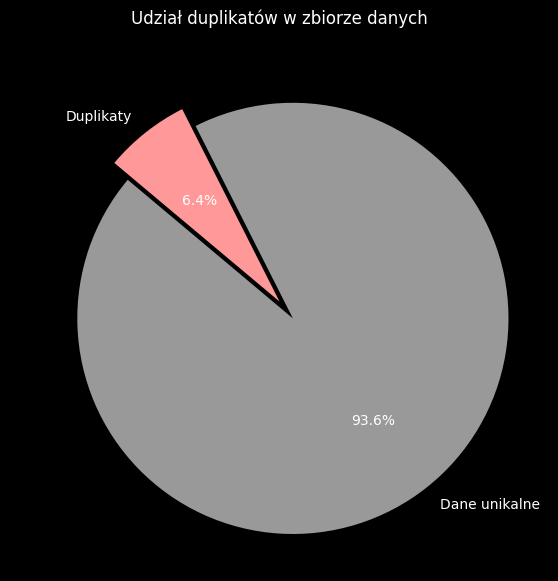

In [1278]:
plt.figure(figsize=(7, 7))
plt.pie([liczba_unikalnych, duplikaty_logiczne],
        labels=['Dane unikalne', 'Duplikaty'],
        autopct='%1.1f%%',
        colors=['#999999','#ff9999'],
        startangle=140,
        explode=(0.1, 0))
plt.title('Udział duplikatów w zbiorze danych')
plt.show()

Obsługa wartości brakujących

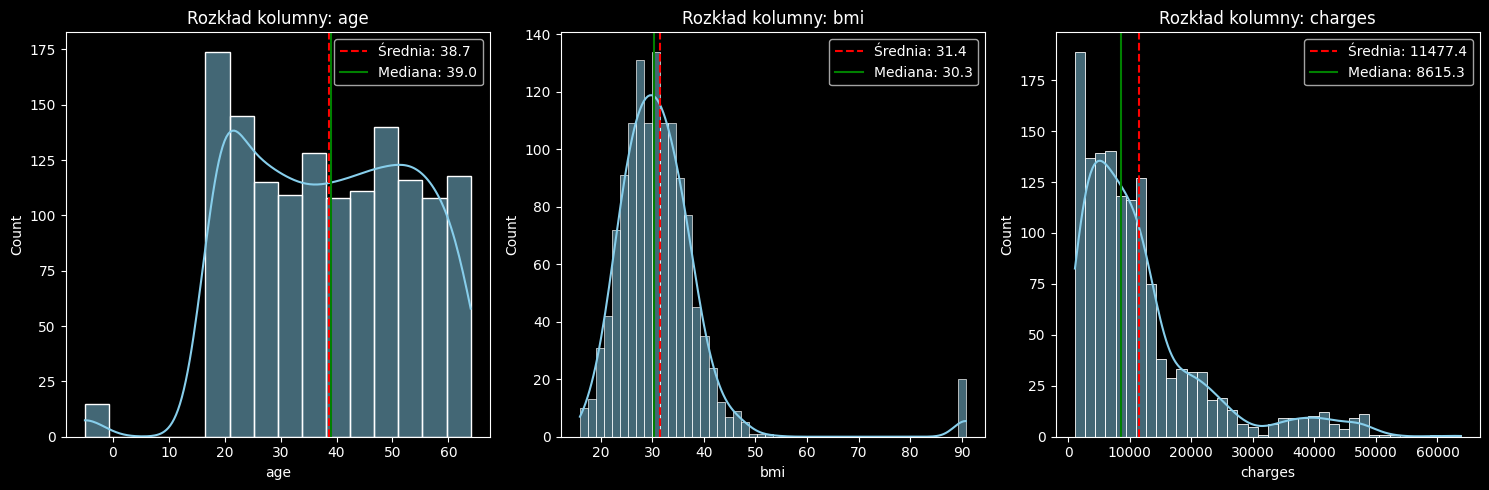

In [1279]:
cols_to_fix = ['age', 'bmi', 'charges']

plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_to_fix):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_zepsuty[col].dropna(), kde=True, color='skyblue')

    # Dodanie linii średniej i mediany
    mean_val = df_zepsuty[col].mean()
    median_val = df_zepsuty[col].median()

    plt.axvline(mean_val, color='red', linestyle='--', label=f'Średnia: {mean_val:.1f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.1f}')

    plt.title(f'Rozkład kolumny: {col}')
    plt.legend()

plt.tight_layout()
plt.show()

Wartość użyta do imputacji średnią: 11477.41
Wartość użyta do imputacji medianą: 8615.30
Różnica: 2862.11


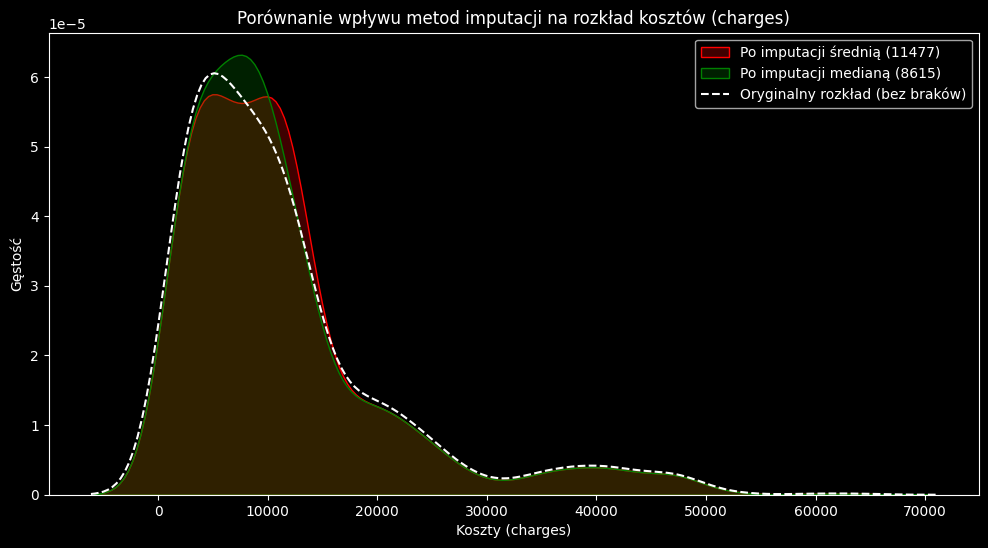

In [1280]:
df_mean_imp = df_zepsuty.copy()
df_median_imp = df_zepsuty.copy()

mean_val = df_zepsuty['charges'].mean()
median_val = df_zepsuty['charges'].median()

df_mean_imp['charges'] = df_mean_imp['charges'].fillna(mean_val)
df_median_imp['charges'] = df_median_imp['charges'].fillna(median_val)

print(f"Wartość użyta do imputacji średnią: {mean_val:.2f}")
print(f"Wartość użyta do imputacji medianą: {median_val:.2f}")
print(f"Różnica: {abs(mean_val - median_val):.2f}")

plt.figure(figsize=(12, 6))

sns.kdeplot(df_mean_imp['charges'], label=f'Po imputacji średnią ({mean_val:.0f})', color='red', fill=True)
sns.kdeplot(df_median_imp['charges'], label=f'Po imputacji medianą ({median_val:.0f})', color='green', fill=True)
sns.kdeplot(df_zepsuty['charges'].dropna(), label='Oryginalny rozkład (bez braków)', color='white', linestyle='--')

plt.title('Porównanie wpływu metod imputacji na rozkład kosztów (charges)')
plt.xlabel('Koszty (charges)')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

In [1281]:
df_cleaned = df_zepsuty.copy()

for col in ['age', 'bmi', 'charges']:
    median_value = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)

print("Imputacja zakończona. Liczba braków po naprawie:")
print(df_cleaned[['age', 'bmi', 'charges']].isnull().sum())

Imputacja zakończona. Liczba braków po naprawie:
age        0
bmi        0
charges    0
dtype: int64


In [1282]:
cat_cols = ['sex', 'smoker', 'region']
df_cleaned['region'] = df_cleaned['region'].str.lower()

for col in cat_cols:
    moda_val = df_cleaned[col].mode()[0]

    print(f"Kolumna: {col:10} | Moda: {moda_val}")

    df_cleaned[col] = df_cleaned[col].fillna(moda_val)

print("\nLiczba braków po imputacji modą:")
print(df_cleaned[cat_cols].isnull().sum())

Kolumna: sex        | Moda: male
Kolumna: smoker     | Moda: no
Kolumna: region     | Moda: southeast

Liczba braków po imputacji modą:
sex       0
smoker    0
region    0
dtype: int64


In [1283]:
procent_brakow = df_cleaned.isnull().mean() * 100

kolumny_do_usuniecia = procent_brakow[procent_brakow > 60].index.tolist()

print(f"Kolumny z ponad 60% braków: {kolumny_do_usuniecia}")

df_cleaned = df_cleaned.drop(columns=kolumny_do_usuniecia)

print(f"Pozostałe kolumny: {df_cleaned.columns.tolist()}")

Kolumny z ponad 60% braków: ['referral_code']
Pozostałe kolumny: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'age_total_months']


## 4.2 Naprawianie zepsutego datasetu
Teraz można zacząć czyszczenie data frame'u

### 4.2.1a. Metoda IQR - identyfikowanie wartości odstających

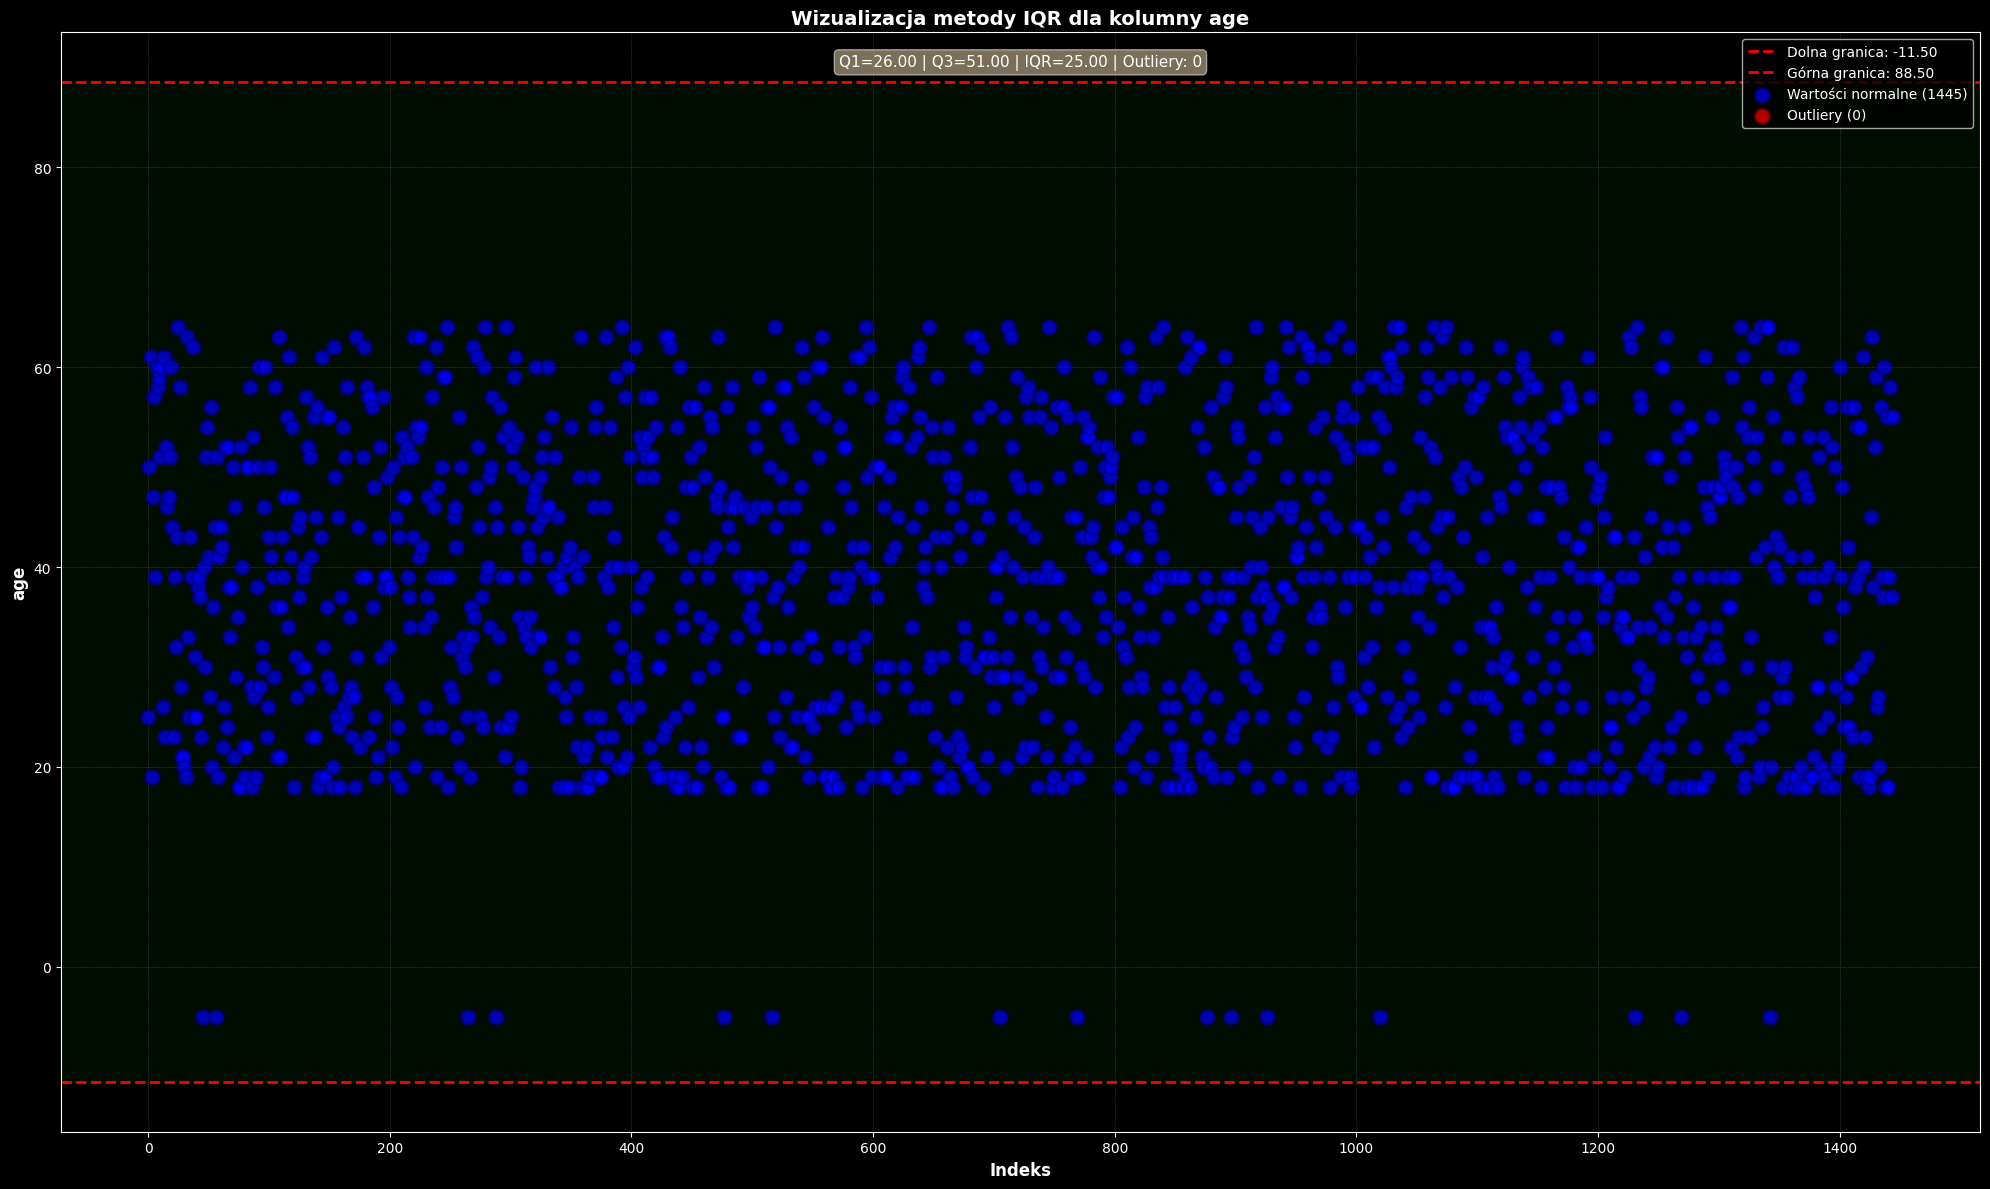

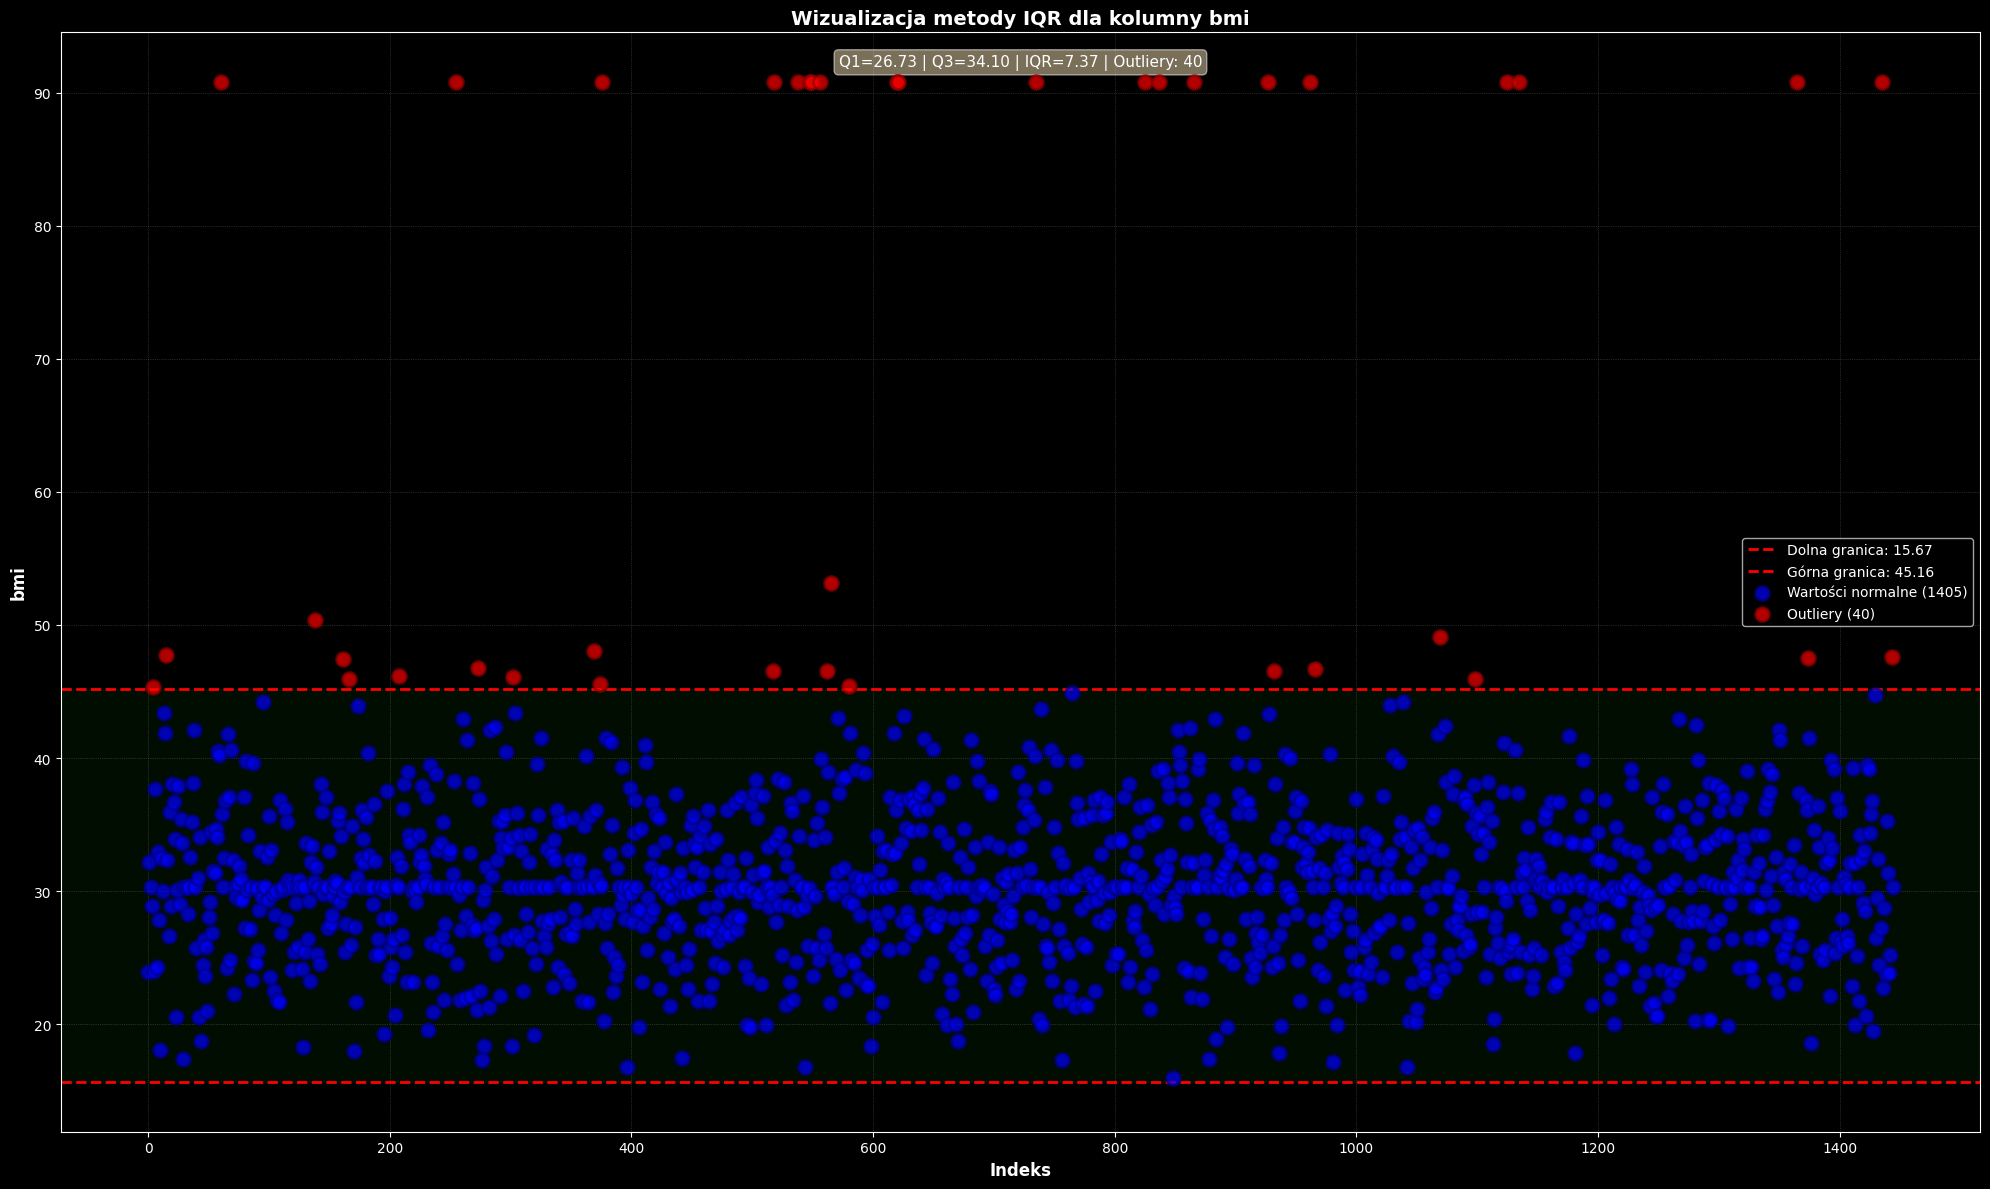

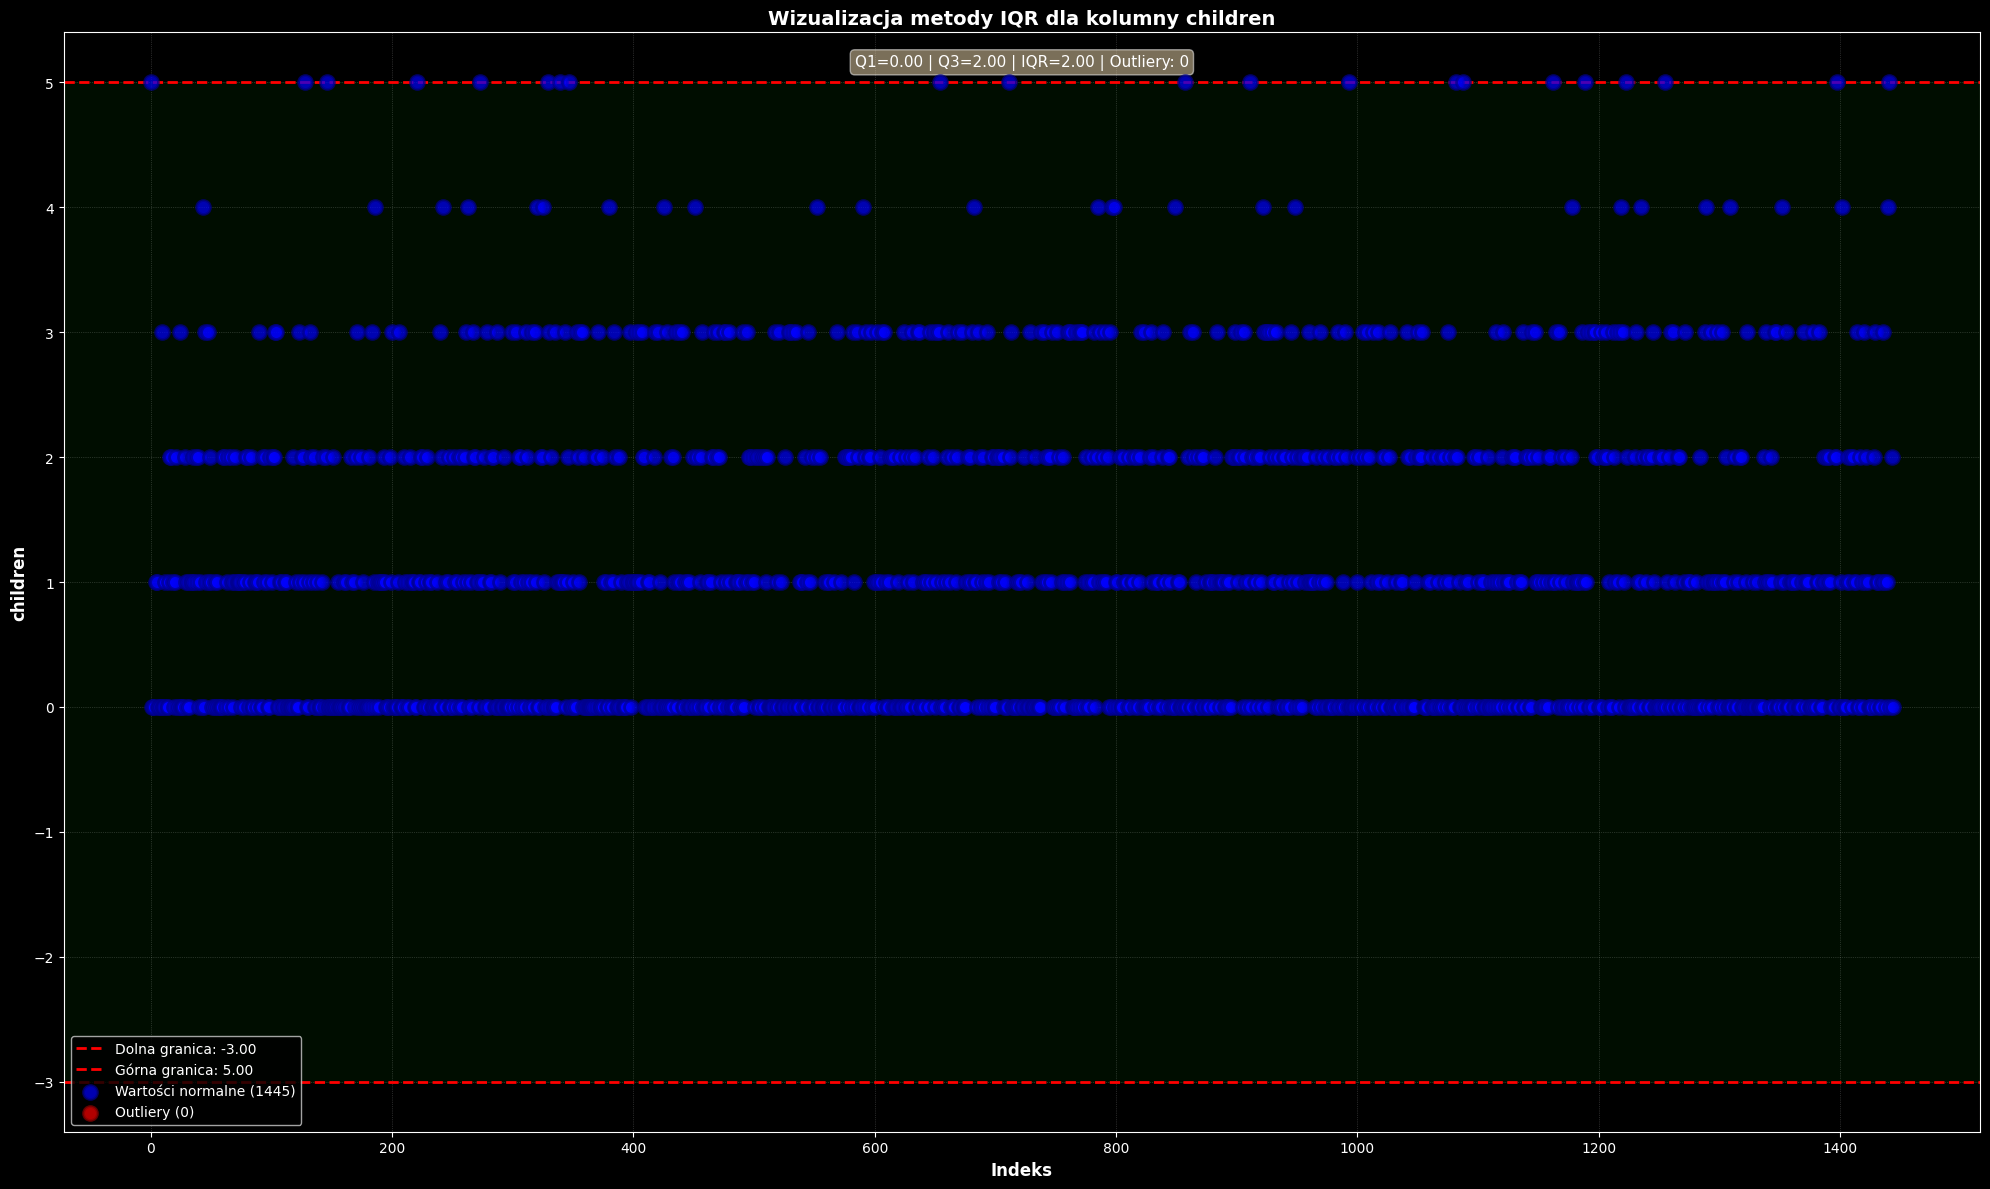

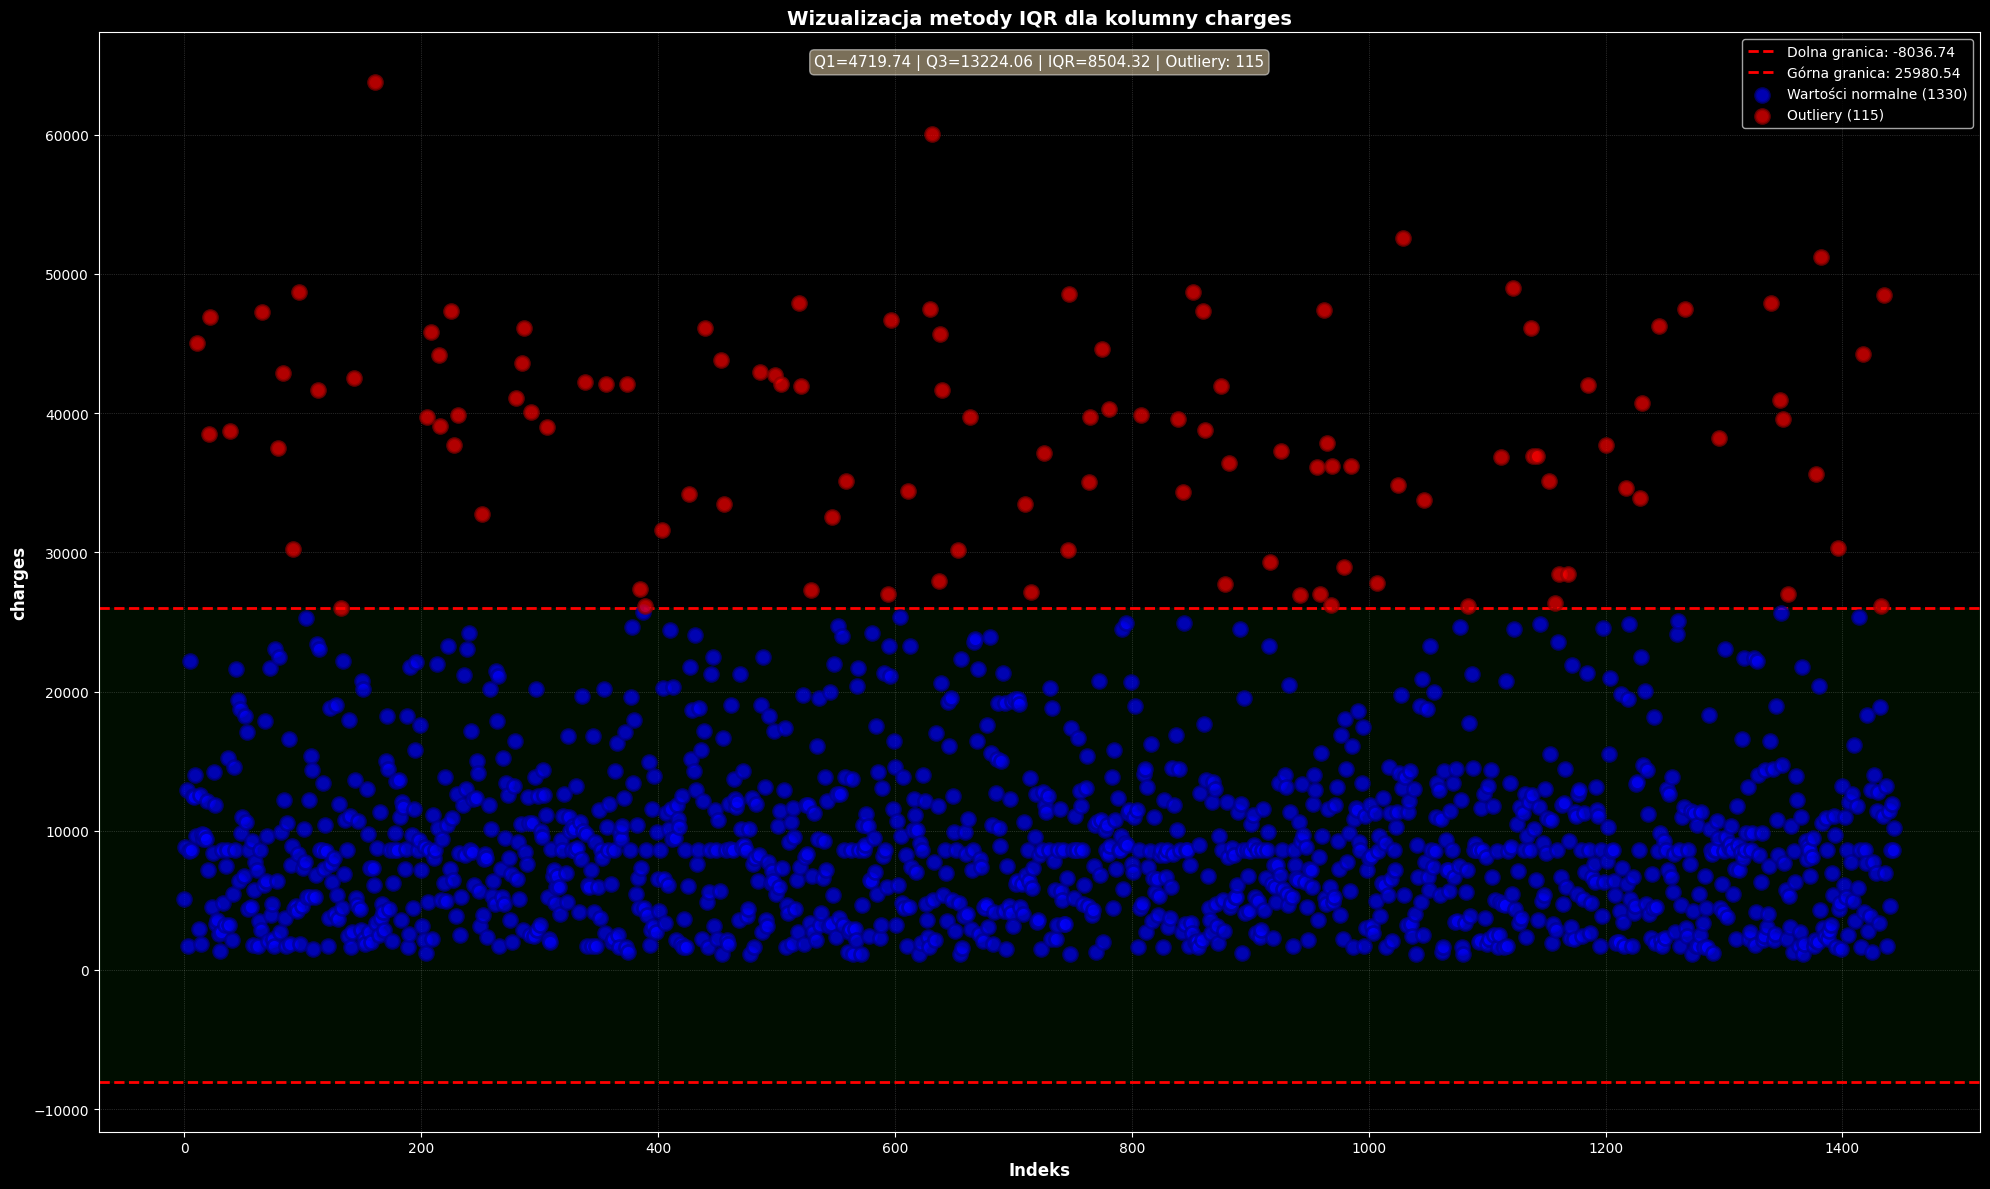

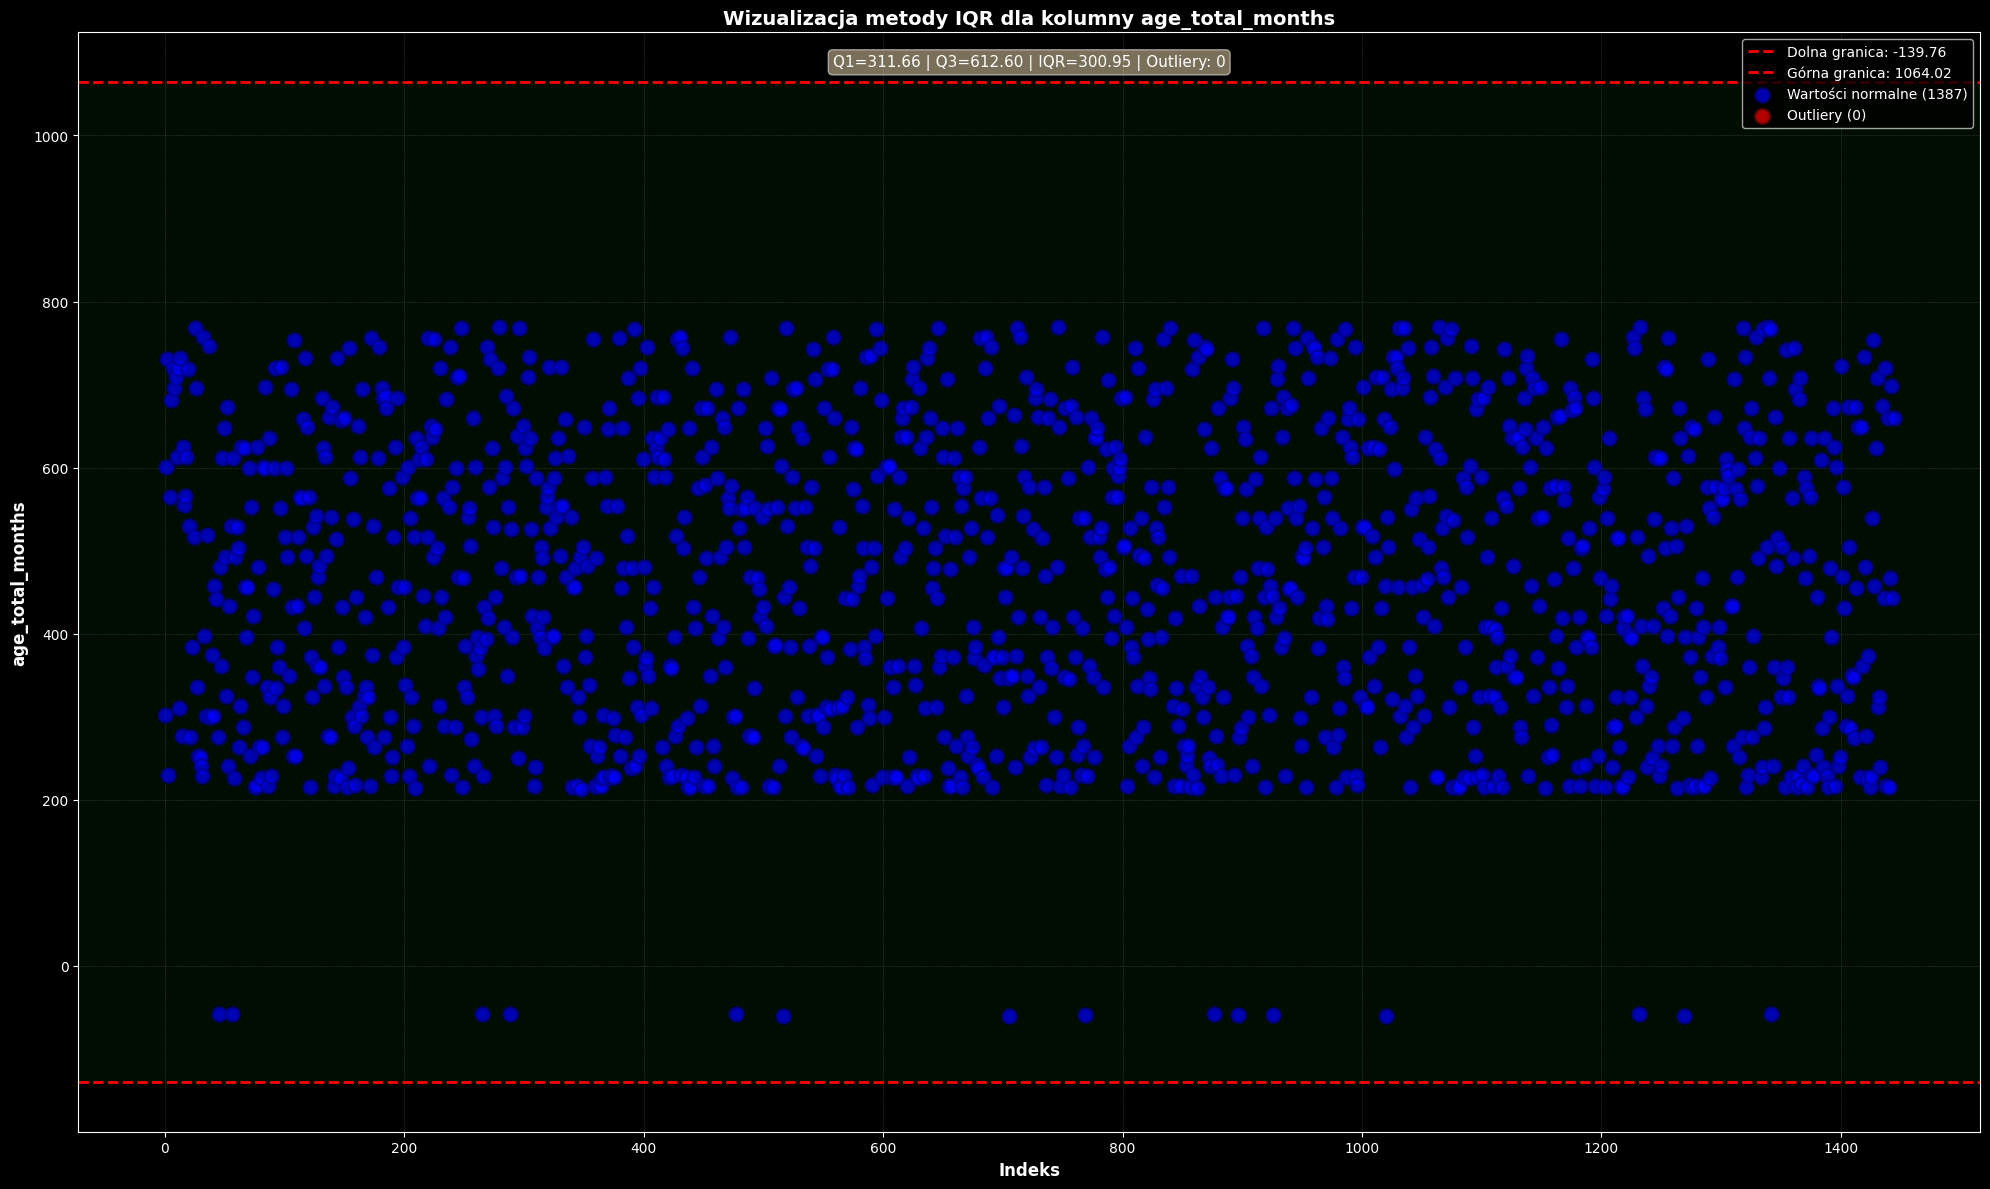

In [1284]:
for col in df_cleaned.select_dtypes(include=[np.number]).columns:
  # Obliczanie Qwantyli 1 i 3
  Q1 =  df_cleaned[col].quantile(0.25)
  Q3 =  df_cleaned[col].quantile(0.75)
  Q1, Q3

  # Obliczanie IQR
  IQR = Q3 - Q1
  IQR

  #Generowanie Wykresu z danych dla konkretnej kolumny

  top_line = (Q1- 1.5 * IQR)
  bottom_line = (Q3 + 1.5 * IQR)
  outliners = df_cleaned[(df_cleaned[col] < top_line) | (df_cleaned[col] > bottom_line)]

  normal = df_cleaned[(df_cleaned[col] >= top_line) & (df_cleaned[col] <= bottom_line)]

  plt.figure(figsize=(20, 12))

  plt.axhspan(top_line, bottom_line, alpha=0.1, color='green')

  plt.axhline(y=top_line, color='red', linestyle='--', linewidth=2,
            label=f'Dolna granica: {top_line:.2f}')
  plt.axhline(y=bottom_line, color='red', linestyle='--', linewidth=2,
            label=f'Górna granica: {bottom_line:.2f}')

  plt.scatter(normal.index, normal[col], c='blue', s=100,
            alpha=0.7, edgecolors='darkblue', linewidth=2,
            label=f'Wartości normalne ({len(normal)})', zorder=5)

  plt.scatter(outliners.index, outliners[col], c='red', s=100,
            alpha=0.7, edgecolors='darkred', linewidth=2,
            label=f'Outliery ({len(outliners)})', zorder=5)

  plt.xlabel('Indeks', fontsize=12, fontweight='bold')
  plt.ylabel(col, fontsize=12, fontweight='bold')
  plt.title('Wizualizacja metody IQR dla kolumny ' + col, fontsize=14, fontweight='bold')
  plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
  plt.legend(loc='best', fontsize=10)

  info = f'Q1={Q1:.2f} | Q3={Q3:.2f} | IQR={IQR:.2f} | Outliery: {len(outliners)}'
  plt.text(0.5, 0.98, info, transform=plt.gca().transAxes,
          fontsize=11, va='top', ha='center',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

  plt.tight_layout()
  plt.show()

In [1285]:
df_cleaned_out= df_cleaned.copy()

Q1_bmi = df_cleaned_out['bmi'].quantile(0.25)
Q3_bmi = df_cleaned_out['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi

top_bmi = Q3_bmi + 1.5 * IQR_bmi
bottom_bmi = Q1_bmi - 1.5 * IQR_bmi

df_cleaned_out['bmi'] = df_cleaned_out['bmi'].clip(lower=bottom_bmi, upper=top_bmi)

print(f"Granica górna (upper bound): {top_bmi:.2f}")
print(f"Maksymalne BMI po IQR: {df_cleaned_out['bmi'].max():.2f}")


Granica górna (upper bound): 45.16
Maksymalne BMI po IQR: 45.16


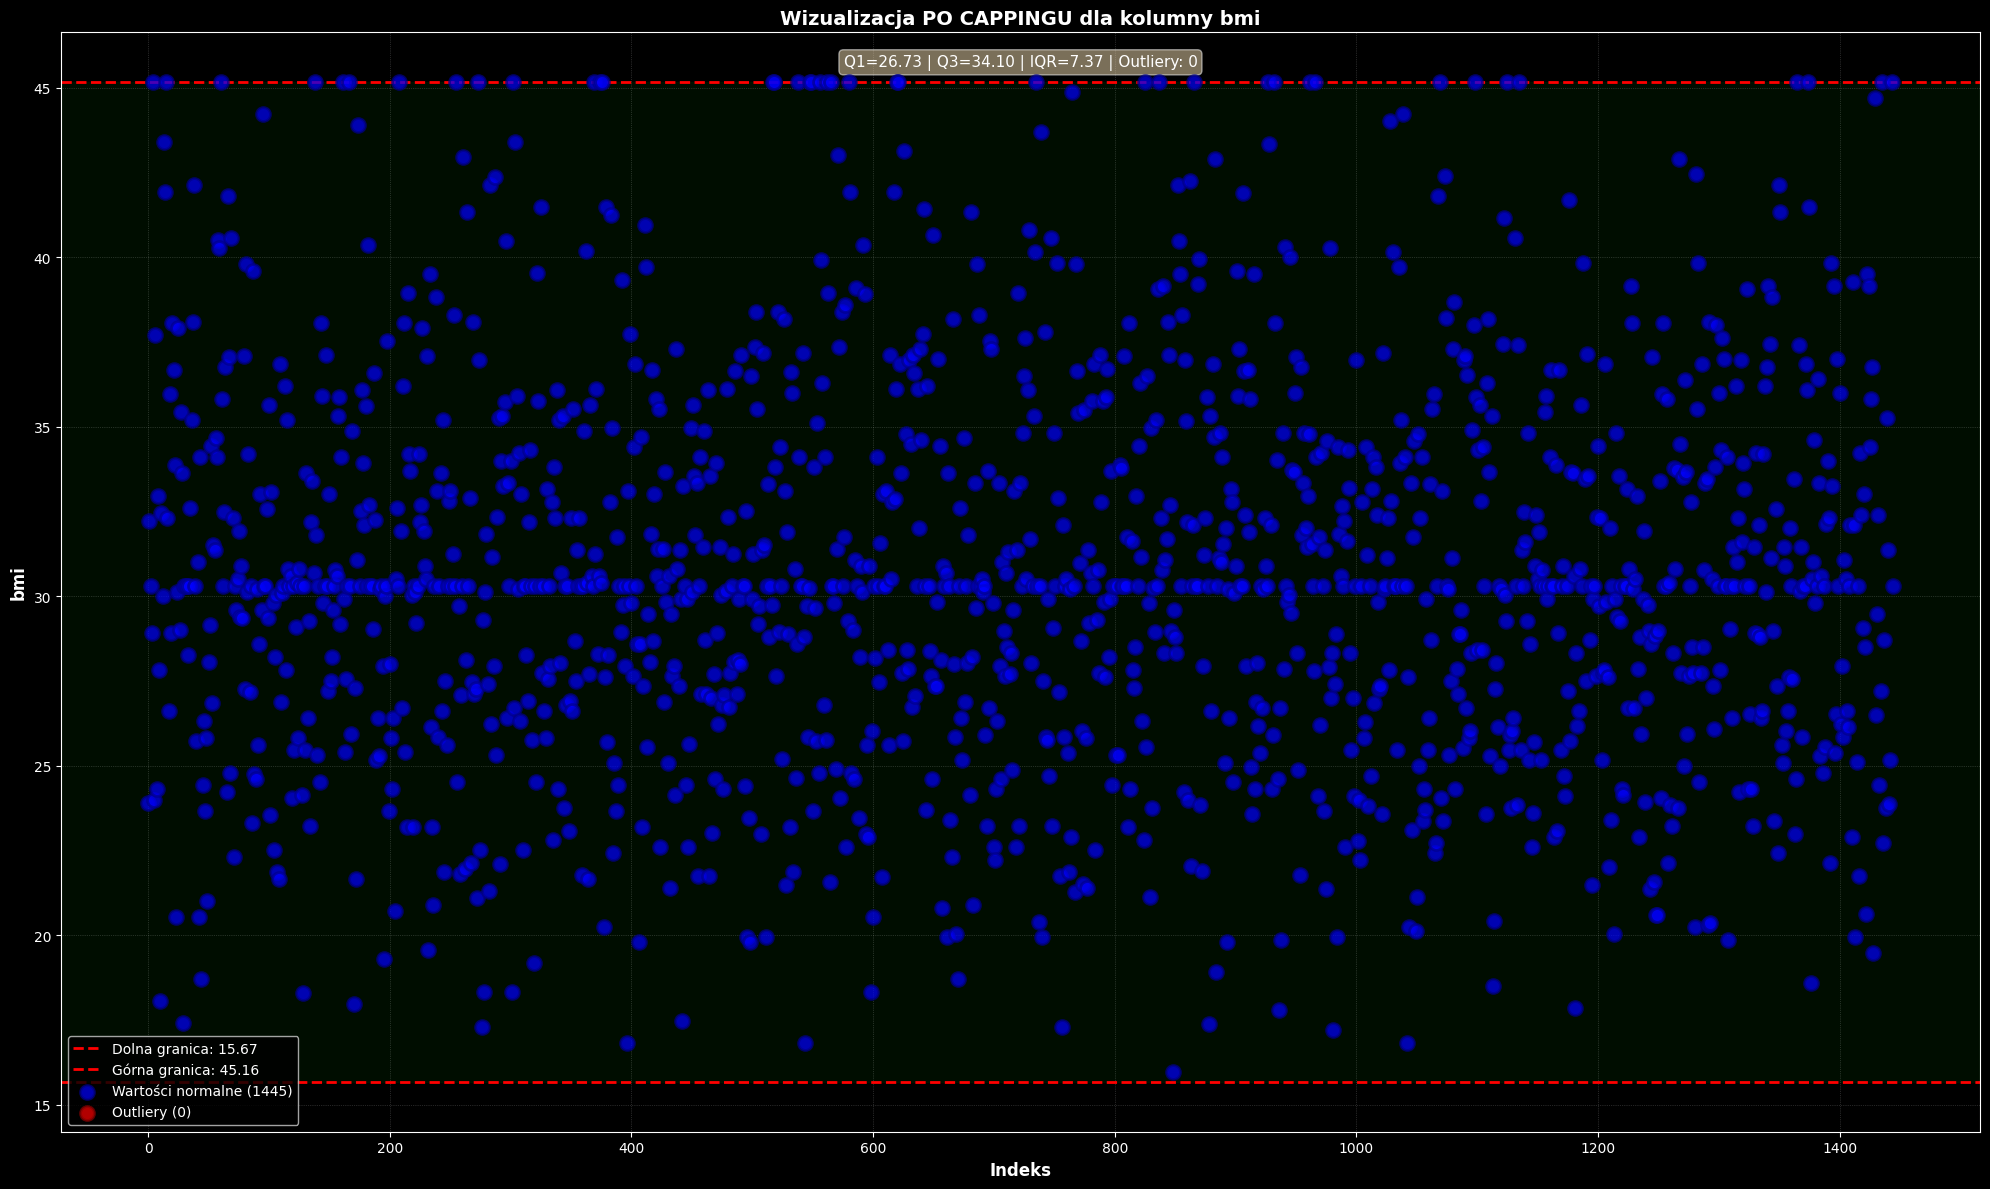

In [1286]:
import matplotlib.pyplot as plt

col = 'bmi'

Q1 = df_cleaned_out[col].quantile(0.25)
Q3 = df_cleaned_out[col].quantile(0.75)
IQR = Q3 - Q1

top_line = (Q1 - 1.5 * IQR)
bottom_line = (Q3 + 1.5 * IQR)

outliners = df_cleaned_out[(df_cleaned_out[col] < top_line) | (df_cleaned_out[col] > bottom_line)]
normal = df_cleaned_out[(df_cleaned_out[col] >= top_line) & (df_cleaned_out[col] <= bottom_line)]

plt.figure(figsize=(20, 12))

plt.axhspan(top_line, bottom_line, alpha=0.1, color='green')

plt.axhline(y=top_line, color='red', linestyle='--', linewidth=2,
            label=f'Dolna granica: {top_line:.2f}')
plt.axhline(y=bottom_line, color='red', linestyle='--', linewidth=2,
            label=f'Górna granica: {bottom_line:.2f}')

plt.scatter(normal.index, normal[col], c='blue', s=100,
            alpha=0.7, edgecolors='darkblue', linewidth=2,
            label=f'Wartości normalne ({len(normal)})', zorder=5)

plt.scatter(outliners.index, outliners[col], c='red', s=100,
            alpha=0.7, edgecolors='darkred', linewidth=2,
            label=f'Outliery ({len(outliners)})', zorder=5)

plt.xlabel('Indeks', fontsize=12, fontweight='bold')
plt.ylabel(col, fontsize=12, fontweight='bold')
plt.title('Wizualizacja PO CAPPINGU dla kolumny ' + col, fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
plt.legend(loc='best', fontsize=10)

info = f'Q1={Q1:.2f} | Q3={Q3:.2f} | IQR={IQR:.2f} | Outliery: {len(outliners)}'
plt.text(0.5, 0.98, info, transform=plt.gca().transAxes,
        fontsize=11, va='top', ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### 4.2.1.b Metoda Isolation Forest - Analizowanie wartości odstających

In [1287]:
from sklearn.ensemble import IsolationForest

df_cleaned_if= df_cleaned_out.copy()

isolation_forest = IsolationForest(contamination=0.05)
df_cleaned_if["outliers"] = isolation_forest.fit_predict(df_cleaned_if[["bmi", "charges"]])

df_cleaned_if[df_cleaned_if["outliers"] ==-1]

age     sex     bmi  children smoker     region      charges  \
11    60.0  female  32.450         0    yes  southeast  45008.95550   
21    23.0  female  36.670         2    yes  northeast  38511.62830   
22    39.0    male  33.880         0    yes  southeast  46889.26120   
29    21.0  female  17.400         1     no  southwest   2585.26900   
44    23.0    male  18.715         0     no  northwest  21595.38229   
...    ...     ...     ...       ...    ...        ...          ...   
1340  59.0  female  36.765         1    yes  northeast  47896.79135   
1350  27.0    male  42.130         0    yes  southeast  39611.75770   
1382  28.0    male  36.400         1    yes  southwest  51194.55914   
1417  54.0    male  34.210         2    yes  southeast  44260.74990   
1435  39.0  female  45.155         1    yes  northeast  48517.56315   

      age_total_months  outliers  
11          720.107748        -1  
21          275.943985        -1  
22                 NaN        -1  
29          251.459046        -1  
44          275.127017        -1  
...                ...       ...  
1340        707.740016        -1  
1350        323.825515        -1  
1382        334.278317        -1  
1417        649.003691        -1  
1435               NaN        -1  

[73 rows x 9 columns]

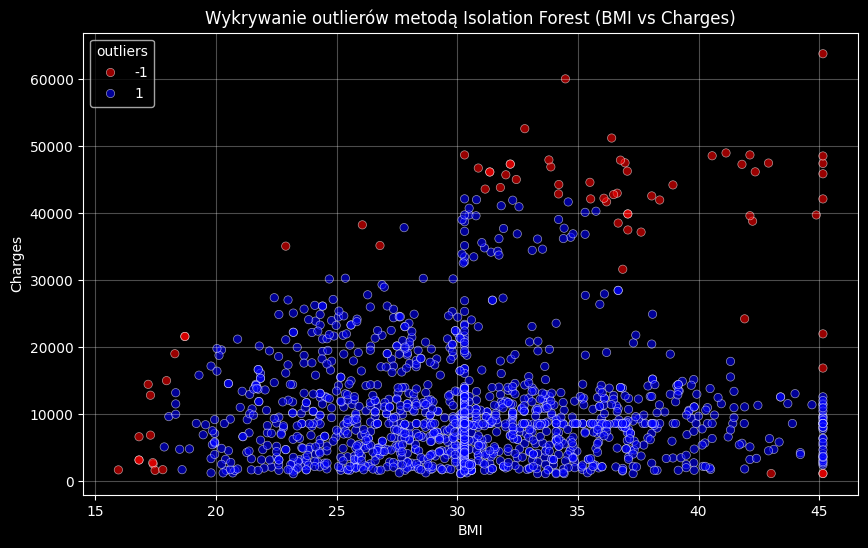

In [1288]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned_if, x="bmi", y="charges", hue="outliers",
                palette={1: "blue", -1: "red"}, alpha=0.6)

plt.title("Wykrywanie outlierów metodą Isolation Forest (BMI vs Charges)")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.grid(True, alpha=0.3)
plt.show()


In [1289]:
import plotly.express as px
fig = px.scatter(df_cleaned_if, x="bmi", y="charges", color="outliers", title="Wartosci odstajace w danych")
fig.show()

In [1290]:
stats_before = df_cleaned['bmi'].describe()
stats_after = df_cleaned_out['bmi'].describe()

comparison_df = pd.DataFrame({
    'Statystyka': stats_before.index,
    'Przed Cappingiem': stats_before.values,
    'Po Cappingu': stats_after.values
})

comparison_df['Różnica'] = comparison_df['Po Cappingu'] - comparison_df['Przed Cappingiem']

print("Wpływ outlierów na statystyki opisowe BMI:")
print(comparison_df.round(2))


Wpływ outlierów na statystyki opisowe BMI:
  Statystyka  Przed Cappingiem  Po Cappingu  Różnica
0      count           1445.00      1445.00     0.00
1       mean             31.31        30.65    -0.66
2        std              9.02         5.80    -3.21
3        min             15.96        15.96     0.00
4        25%             26.73        26.73     0.00
5        50%             30.30        30.30     0.00
6        75%             34.10        34.10     0.00
7        max             90.77        45.16   -45.62


### 4.2.2. Usuwanie duplikatów

In [1291]:
df_to_clean = df_cleaned_out.copy()

In [1292]:
df_to_clean = df_to_clean.drop_duplicates()

In [1293]:
logical_columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

duplicates_count = df_to_clean.duplicated(subset=logical_columns).sum()
print(f"Liczba znalezionych duplikatów logicznych: {duplicates_count}")

df_cleaned = df_to_clean.drop_duplicates(subset=logical_columns, keep='first')

print(f"Liczba wierszy po usunięciu duplikatów: {len(df_cleaned)}")

Liczba znalezionych duplikatów logicznych: 104
Liczba wierszy po usunięciu duplikatów: 1338


### 4.2.3. Naprawa typów danych - usuwanie stringów z kolumn numerycznych

In [1294]:
numeric_columns = df_to_clean.select_dtypes([np.number]).columns

for col in numeric_columns:
    if col in df_to_clean.columns:
        df_to_clean[col] = pd.to_numeric(df_to_clean[col], errors='coerce')

### 4.2.4. Usuwanie wartości negatywnych

In [1295]:
df_to_clean = df_to_clean[(df_to_clean[numeric_columns] >= 0).all(axis=1)]

### 4.2.5. Analiza i uzupełnianie brakujących danych

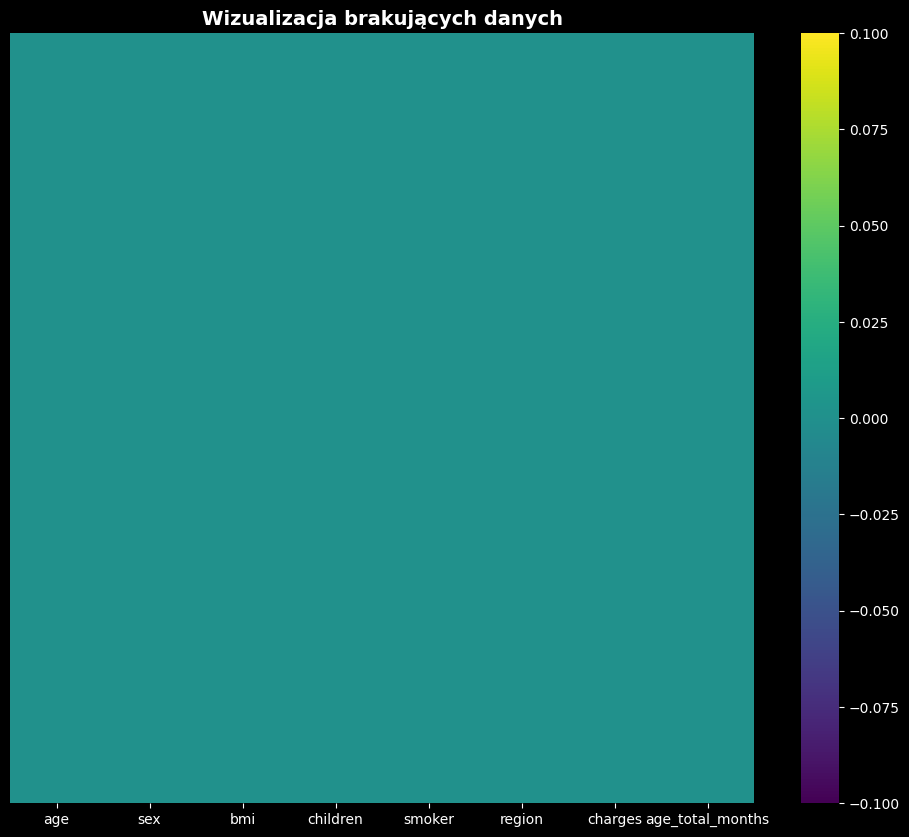

In [1296]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_to_clean.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Wizualizacja brakujących danych', fontsize=14, fontweight='bold')
plt.show()

In [1297]:
for col in numeric_columns:
    if col in df_to_clean.columns:
        if df_to_clean[col].isnull().sum() > 0:
            median_value = df_to_clean[col].median()
            df_to_clean[col].fillna(median_value, inplace=True)


### 4.2.6. Resetowanie indeksów

In [1298]:
df_to_clean = df_to_clean.reset_index(drop=True)
df_to_clean

age     sex     bmi  children smoker     region      charges  \
0     25.0    male  23.900         5     no  southwest   5080.09600   
1     50.0    male  32.205         0     no  northwest   8835.26495   
2     61.0    male  30.305         0     no  northwest  12950.07120   
3     19.0  female  28.900         0     no  southwest   1743.21400   
4     47.0  female  45.155         1     no  southeast   8569.86180   
...    ...     ...     ...       ...    ...        ...          ...   
1367  18.0  female  31.350         4     no  northeast   4561.18850   
1368  39.0  female  23.870         5     no  southeast   8582.30230   
1369  58.0    male  25.175         0     no  northeast  11931.12525   
1370  37.0  female  45.155         2    yes  southwest   8615.30000   
1371  55.0    male  30.305         0     no  southwest  10214.63600   

      age_total_months  
0           301.700135  
1           600.175245  
2           730.736119  
3           229.209494  
4           564.646449  
...                ...  
1367        215.443903  
1368        467.139453  
1369        698.323267  
1370        442.477285  
1371        660.023469  

[1372 rows x 8 columns]

In [1299]:
validation_rules = {
    'age': (0, 100),
    'bmi': (10, 60),
    'children': (0, 10),
    'charges': (0, 100000),
    'age_total_months': (200,1200)
}

print("Raport walidacji domenowej:")
for col, (min_val, max_val) in validation_rules.items():
    if col in df_to_clean.columns:
        invalid_count = df_to_clean[(df_to_clean[col] < min_val) | (df_to_clean[col] > max_val)].shape[0]
        actual_min = df_to_clean[col].min()
        actual_max = df_to_clean[col].max()

        status = "OK" if invalid_count == 0 else f"ALARM: {invalid_count} błędów"
        print(f"- {col:8}: {status} (Zakres: {actual_min:.2f} - {actual_max:.2f})")

Raport walidacji domenowej:
- age     : OK (Zakres: 18.00 - 64.00)
- bmi     : OK (Zakres: 15.96 - 45.16)
- children: OK (Zakres: 0.00 - 5.00)
- charges : OK (Zakres: 1121.87 - 63770.43)
- age_total_months: OK (Zakres: 213.16 - 769.57)


## 4.3. Detekcja wartości odstających - Isolation Forest po wstępnych poprawkach

In [1300]:
from sklearn.ensemble import IsolationForest

features_for_isolation = ['age', 'charges']
X_isolation = df_to_clean[features_for_isolation].dropna()

isolation_forest = IsolationForest(contamination=0.006, random_state=42)
outliers_pred = isolation_forest.fit_predict(X_isolation)

df_to_clean['outliers'] = 1
df_to_clean.loc[X_isolation.index, 'outliers'] = outliers_pred

In [1301]:
df_to_clean[df_to_clean['outliers'] == -1]

age     sex     bmi  children smoker     region      charges  \
153   54.0  female  45.155         0    yes  southeast  63770.42801   
212   63.0  female  32.200         2    yes  southwest  47305.30500   
491   64.0  female  33.800         1    yes  southwest  47928.03000   
599   52.0    male  34.485         3    yes  northwest  60021.39897   
728   19.0    male  44.880         0    yes  southeast  39722.74620   
818   63.0  female  32.200         2    yes  southwest  47305.30500   
820   18.0  female  42.240         0    yes  southeast  38792.68560   
976   60.0    male  32.800         0    yes  southwest  52590.82939   
1312  28.0    male  36.400         1    yes  southwest  51194.55914   

      age_total_months  outliers  
153         650.272536        -1  
212         754.376195        -1  
491         768.474042        -1  
599         623.739580        -1  
728         229.263854        -1  
818         754.073545        -1  
820         214.306501        -1  
976         719.598014        -1  
1312        334.278317        -1

### 4.3.1. Wizualizacja wartości odstających

In [1302]:
import plotly.express as px

fig = px.scatter(df_to_clean, x='age', y='charges',
                 color='outliers',
                 color_discrete_map={1: 'blue', -1: 'red'},
                 title='Wartości odstające w danych (Isolation Forest)',
                 labels={'outliers': 'Typ', 'age': 'Wiek', 'charges': 'Koszty'},
                 hover_data=['bmi', 'smoker']
                 )
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

Saphiro - Wilk i Q-Q plot

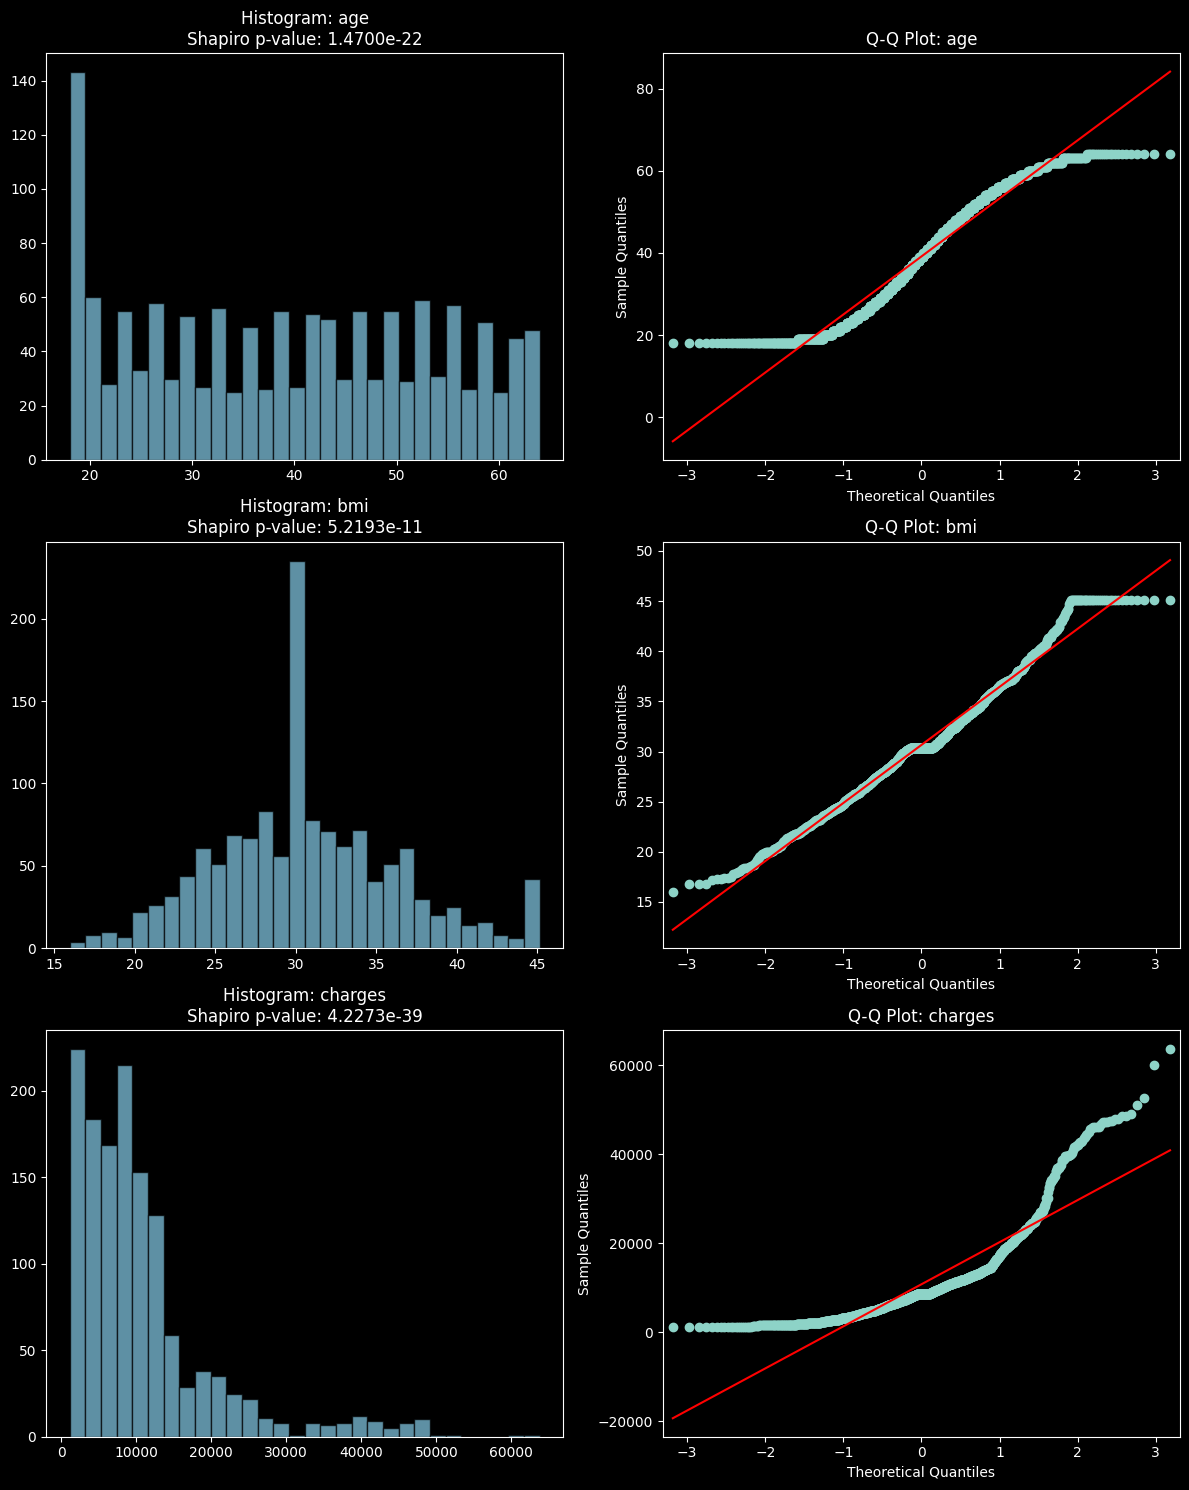

Zmienna age     : p-value = 1.4700e-22 -> Brak normalności
Zmienna bmi     : p-value = 5.2193e-11 -> Brak normalności
Zmienna charges : p-value = 4.2273e-39 -> Brak normalności


In [1303]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

numerical_cols = ['age', 'bmi', 'charges']

fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(12, 15))

for i, col in enumerate(numerical_cols):
    data = df_to_clean[col].dropna()

    stat, p_value = stats.shapiro(data)

    axes[i, 0].hist(data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'Histogram: {col}\nShapiro p-value: {p_value:.4e}')

    sm.qqplot(data, line='s', ax=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot: {col}')

plt.tight_layout()
plt.show()

for col in numerical_cols:
    stat, p_value = stats.shapiro(df_to_clean[col].dropna())
    result = "Normalny" if p_value > 0.05 else "Brak normalności"
    print(f"Zmienna {col:8}: p-value = {p_value:.4e} -> {result}")

Distribution plot dla najważniejszych zmiennych (przed/po
transformacji)

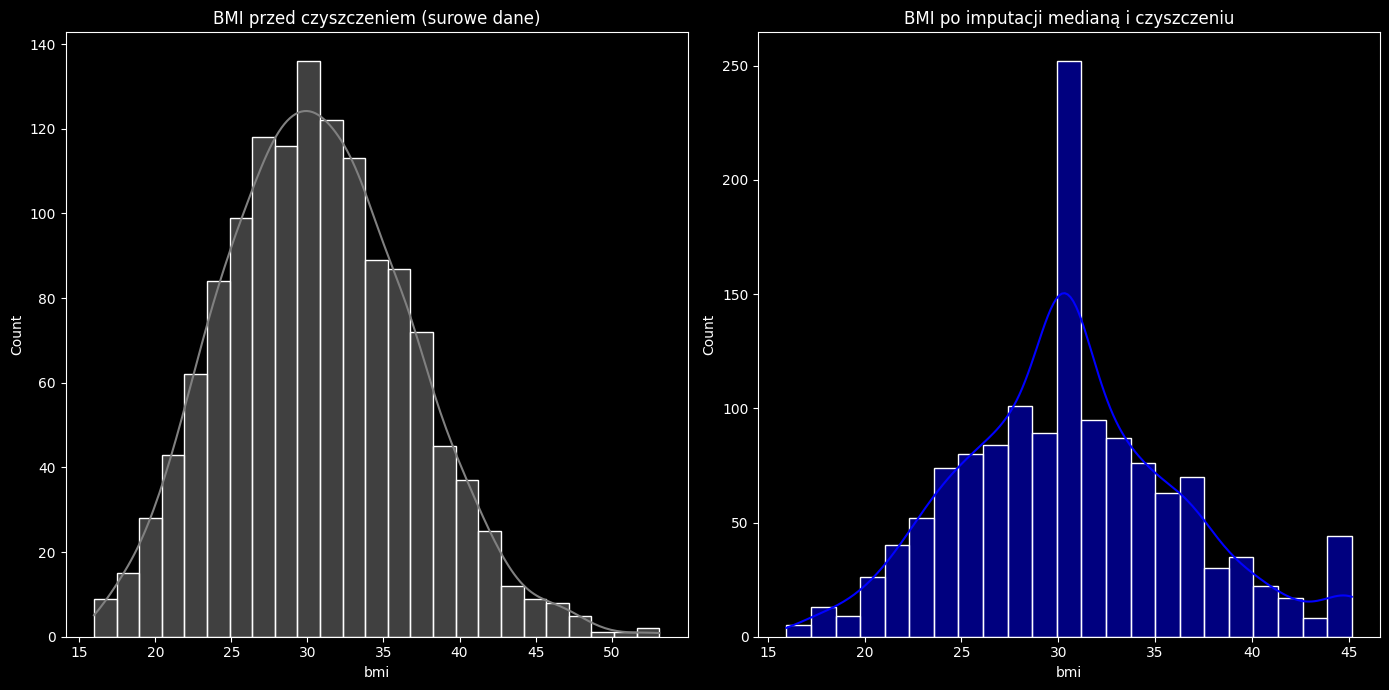

In [1304]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

sns.histplot(df['bmi'], kde=True, ax=ax[0], color='gray')
ax[0].set_title('BMI przed czyszczeniem (surowe dane)')

sns.histplot(df_to_clean['bmi'], kde=True, ax=ax[1], color='blue')
ax[1].set_title('BMI po imputacji medianą i czyszczeniu')

plt.tight_layout()
plt.show()

Correlation Heatmap (Przed i po Feature Engineering)

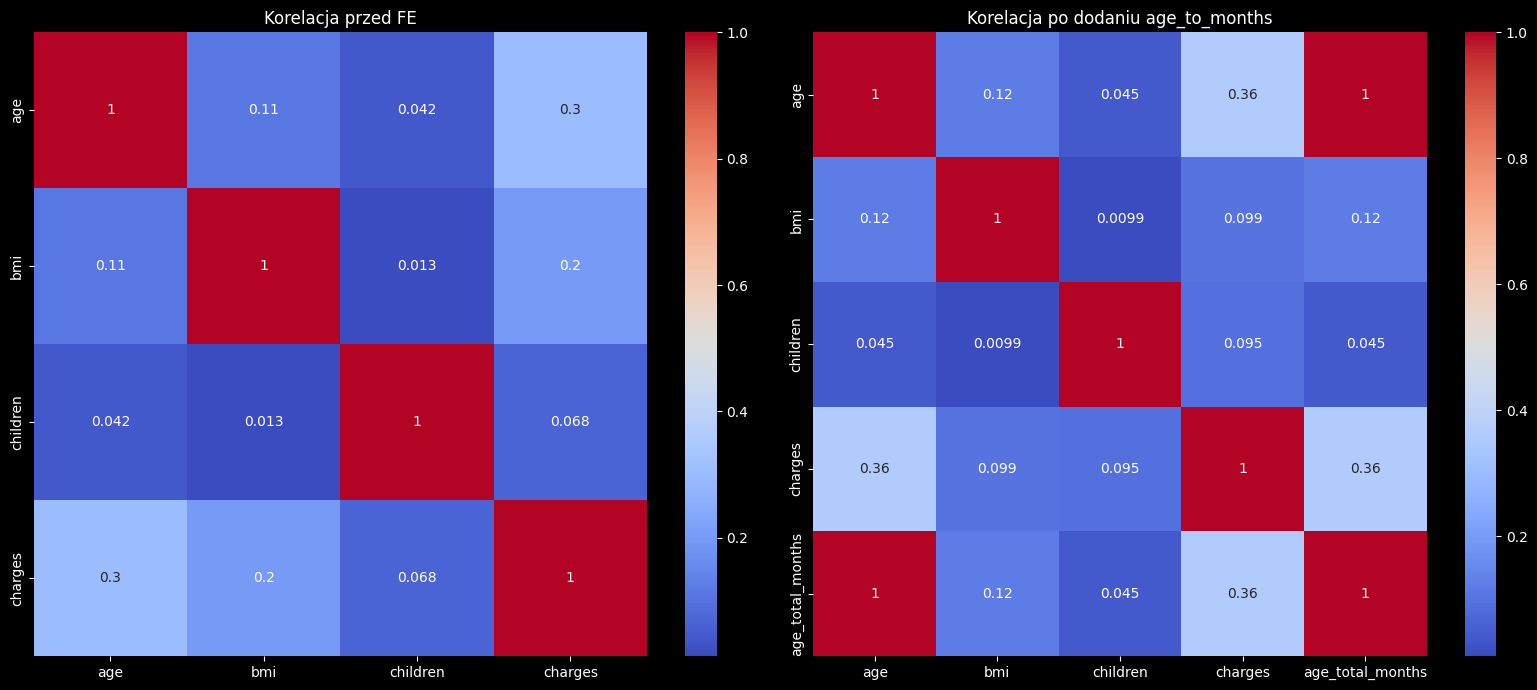

In [1305]:
cols_before = ['age', 'bmi', 'children', 'charges']
cols_after = ['age', 'bmi', 'children', 'charges', 'age_total_months']

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(df[cols_before].corr(), annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Korelacja przed FE')

sns.heatmap(df_to_clean[cols_after].corr(), annot=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Korelacja po dodaniu age_to_months')

plt.tight_layout()
plt.show()

Violin Plot (Wykrywanie outlierów)

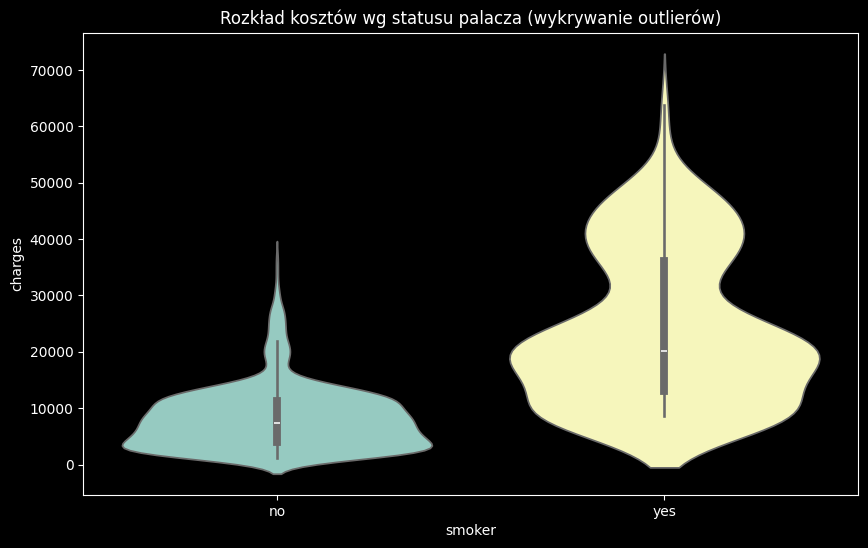

In [1306]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_to_clean,
               x='smoker',
               y='charges',
               hue='smoker',
               legend=False,
               palette='Set3')
plt.title('Rozkład kosztów wg statusu palacza (wykrywanie outlierów)')
plt.show()


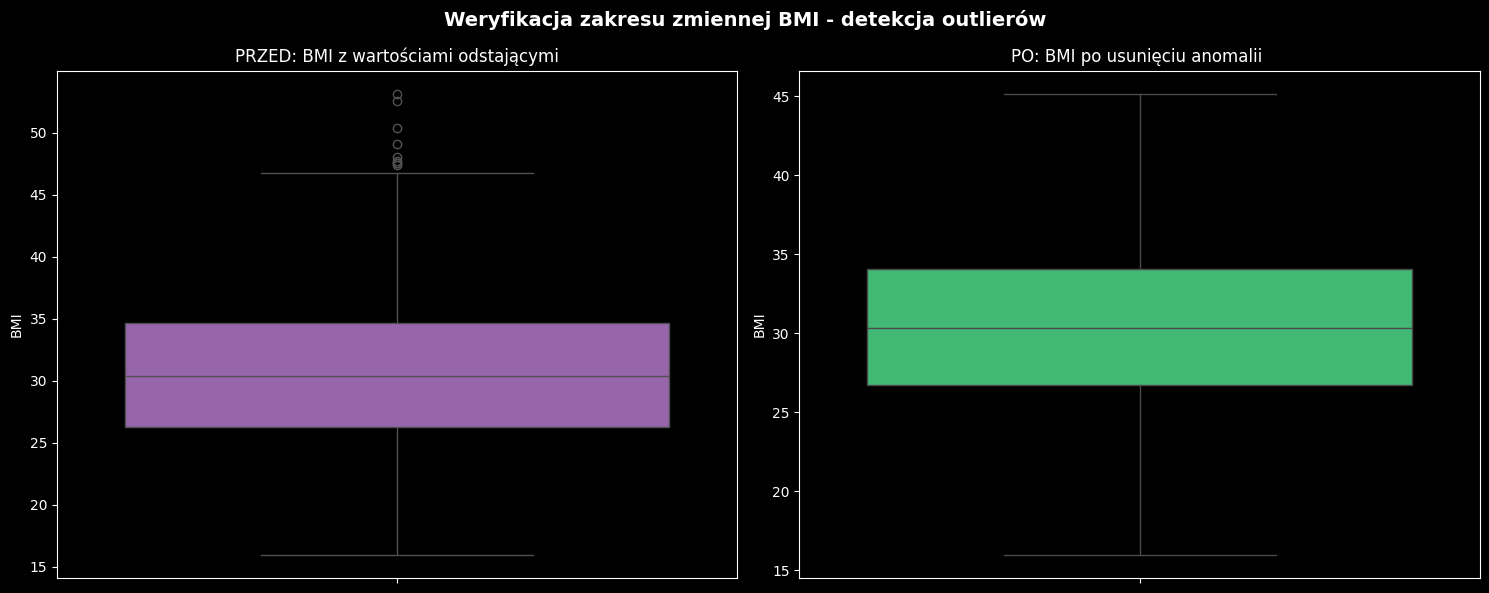

In [1307]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=df, y='bmi', color='#9b59b6', ax=ax[0])
ax[0].set_title('PRZED: BMI z wartościami odstającymi', fontsize=12)
ax[0].set_ylabel('BMI')

sns.boxplot(data=df_to_clean, y='bmi', color='#2ecc71', ax=ax[1])
ax[1].set_title('PO: BMI po usunięciu anomalii ', fontsize=12)
ax[1].set_ylabel('BMI')

plt.suptitle('Weryfikacja zakresu zmiennej BMI - detekcja outlierów', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Scatter Plot (Relacje między zmiennymi)

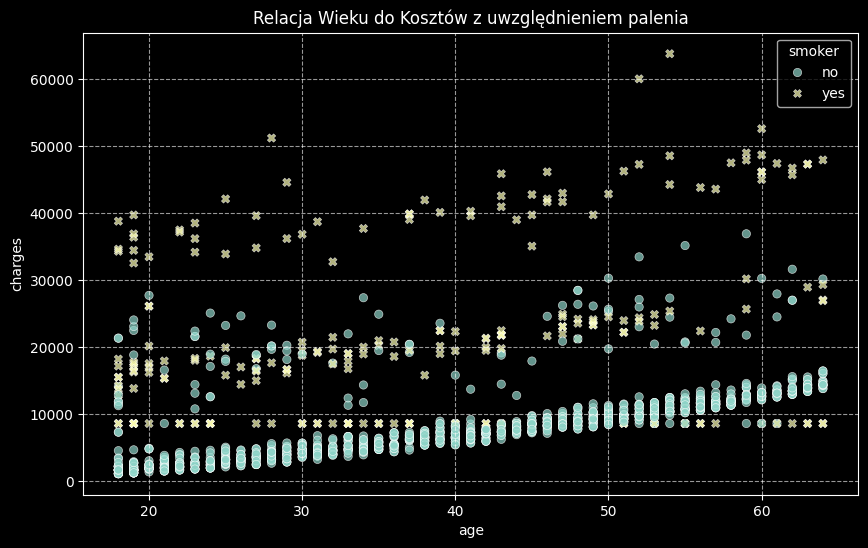

In [1308]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_to_clean, x='age', y='charges', hue='smoker', style='smoker', alpha=0.7)
plt.title('Relacja Wieku do Kosztów z uwzględnieniem palenia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 4.4. Analiza głównych składowych (PCA)

In [1309]:
df_to_clean.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'age_total_months', 'outliers'],
      dtype='str')

In [1310]:
df_to_clean = df_to_clean.drop(columns=['outliers'])

In [1311]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_features = ['age', 'bmi', 'charges']
X_pca = df_to_clean[pca_features].dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

df_to_clean['PC1'] = np.nan
df_to_clean['PC2'] = np.nan
df_to_clean.loc[X_pca.index, 'PC1'] = principal_components[:, 0]
df_to_clean.loc[X_pca.index, 'PC2'] = principal_components[:, 1]

pca.explained_variance_ratio_

array([0.4726028 , 0.31439378])

### 4.4.1. Wizualizacja komponentów głównych

In [1312]:
fig = px.scatter(df_to_clean.dropna(subset=['PC1', 'PC2']),
                 x='PC1', y='PC2',
                 color='charges',
                 title='Wizualizacja głównych składowych (PCA)',
                 color_continuous_scale='Viridis',
                 labels={'charges': 'Koszty'})
fig.update_traces(marker=dict(size=7))
fig.show()

## 4.4a. Wizualizacja redukcji wymiarowości - t-SNE

In [1313]:
tsne_features = ['age', 'bmi', 'charges']

df_to_clean[tsne_features].corr()

age       bmi   charges
age      1.000000  0.119754  0.360351
bmi      0.119754  1.000000  0.099293
charges  0.360351  0.099293  1.000000

In [1314]:
from sklearn.manifold import TSNE

X_tsne = df_to_clean[tsne_features].dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_tsne)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=2000, learning_rate=200)
tsne_results = tsne.fit_transform(scaled_data)

df_to_clean['tSNE1'] = np.nan
df_to_clean['tSNE2'] = np.nan
df_to_clean.loc[X_tsne.index, 'tSNE1'] = tsne_results[:, 0]
df_to_clean.loc[X_tsne.index, 'tSNE2'] = tsne_results[:, 1]

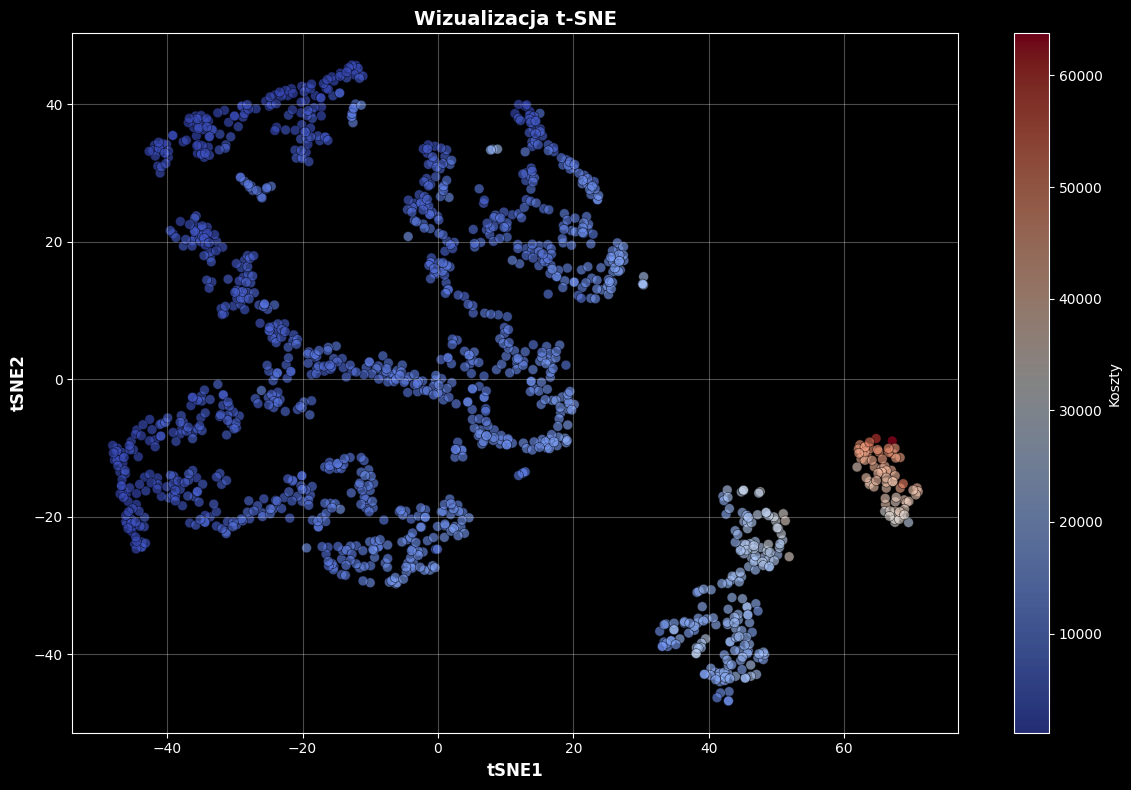

In [1315]:
df_tsne_plot = df_to_clean.dropna(subset=['tSNE1', 'tSNE2'])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_tsne_plot['tSNE1'], df_tsne_plot['tSNE2'],
                     c=df_tsne_plot['charges'],
                     cmap='coolwarm',
                     s=50,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
plt.colorbar(scatter, label='Koszty')
plt.xlabel('tSNE1', fontsize=12, fontweight='bold')
plt.ylabel('tSNE2', fontsize=12, fontweight='bold')
plt.title('Wizualizacja t-SNE', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4.4b. Wizualizacja redukcji wymiarowości - UMAP

In [1316]:
import umap

umap_features = ['age', 'charges']
X_umap = df_to_clean[umap_features].dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_umap)

reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
umap_results = reducer.fit_transform(scaled_data)

df_to_clean['UMAP1'] = np.nan
df_to_clean['UMAP2'] = np.nan
df_to_clean.loc[X_umap.index, 'UMAP1'] = umap_results[:, 0]
df_to_clean.loc[X_umap.index, 'UMAP2'] = umap_results[:, 1]

ImportError: Numba needs NumPy 2.3 or less. Got NumPy 2.4.

In [1317]:
df_umap_plot = df_to_clean.dropna(subset=['UMAP1', 'UMAP2'])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_umap_plot['UMAP1'], df_umap_plot['UMAP2'],
                     c=df_umap_plot['charges'],
                     cmap='Spectral',
                     s=50,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
plt.colorbar(scatter, label='Koszty')
plt.xlabel('UMAP1', fontsize=12, fontweight='bold')
plt.ylabel('UMAP2', fontsize=12, fontweight='bold')
plt.title('Wizualizacja UMAP', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

KeyError: ['UMAP1', 'UMAP2']

## 4.5. Interaktywna analiza zależności

In [1318]:
import altair as alt

df_altair = df_to_clean.dropna(subset=['age', 'bmi', 'charges']).copy()

chart = alt.Chart(df_altair).mark_circle(size=60).encode(
    x=alt.X('age:Q', title=' (Wiek)'),
    y=alt.Y('charges:Q', title='koszty'),
    color=alt.Color('bmi:Q', scale=alt.Scale(scheme='viridis'), title='bmi'),
    tooltip=['age', 'bmi', 'charges']
).properties(
    width=700,
    height=500,
    title='Interaktywna wizualizacja zależności'
).interactive()

chart

alt.Chart(...)

## 4.5a. Analiza macierzy korelacji

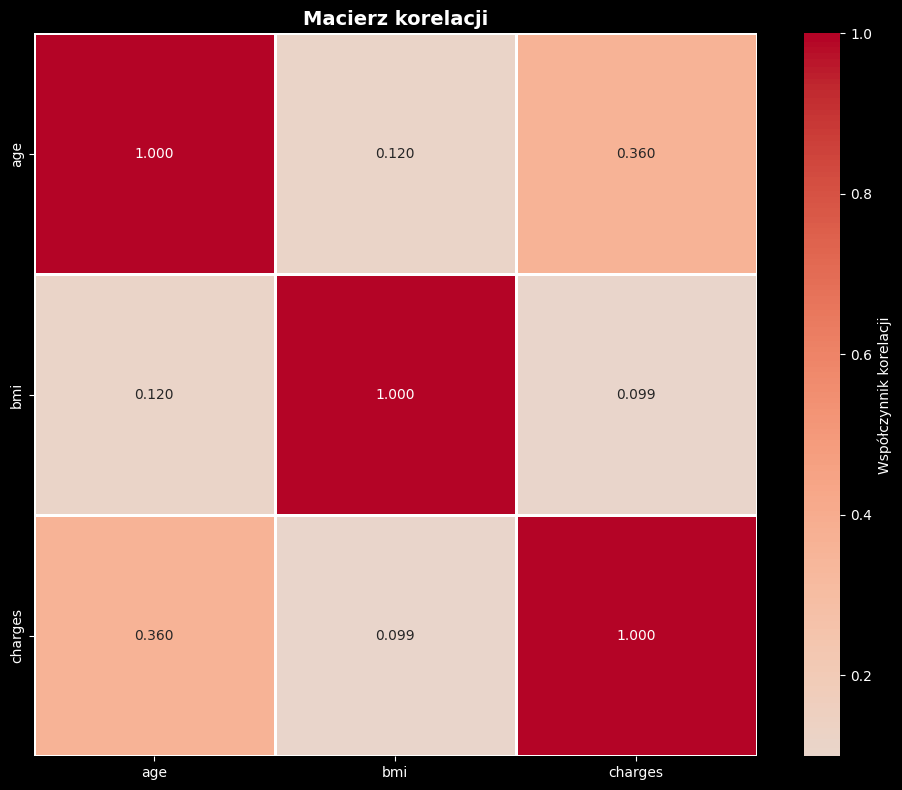

In [1319]:
correlation_features = ['age', 'bmi', 'charges']
df_corr = df_to_clean[correlation_features].dropna()
correlation_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            center=0, fmt='.3f',
            square=True, linewidths=1,
            cbar_kws={'label': 'Współczynnik korelacji'})
plt.title('Macierz korelacji', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.6. Testy statystyczne - ANOVA

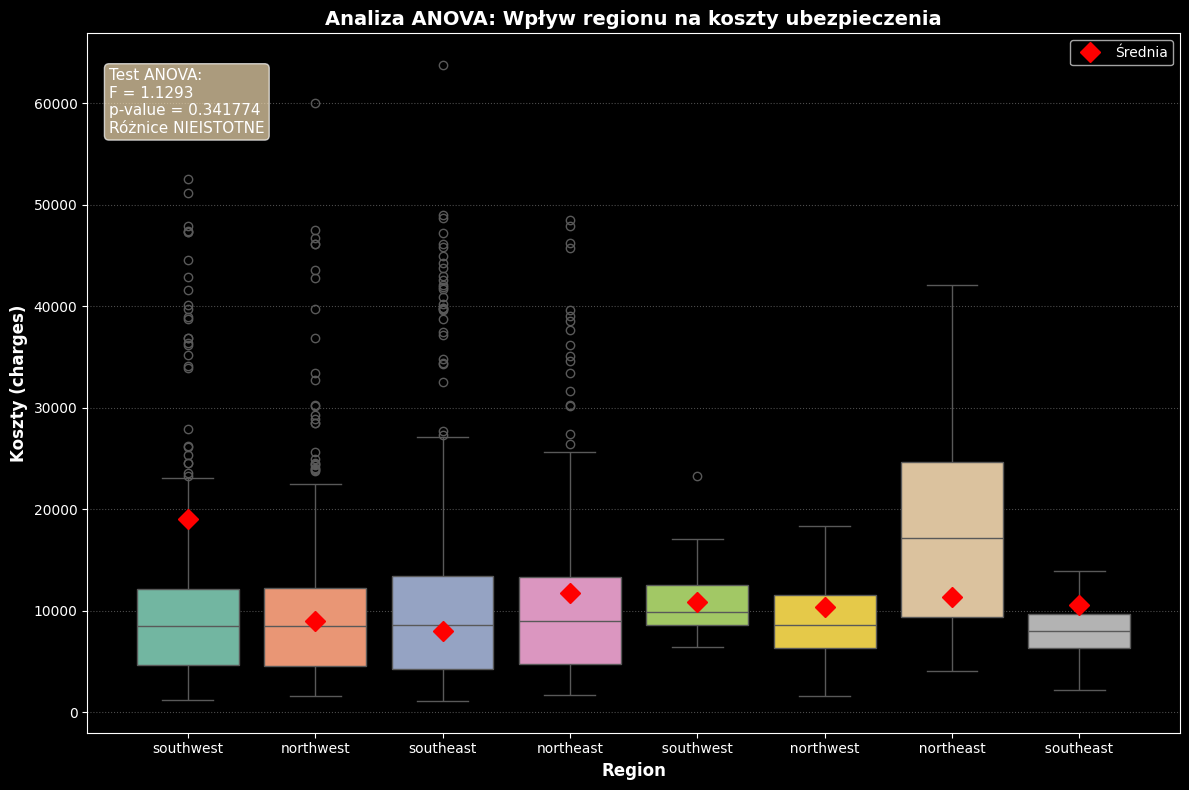

               df        sum_sq       mean_sq         F    PR(>F)
C(region)     7.0  7.068623e+08  1.009803e+08  1.129325  0.341774
Residual   1364.0  1.219641e+11  8.941652e+07       NaN       NaN


In [1320]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns

df_anova = df_to_clean.dropna(subset=['charges', 'region']).copy()

model = ols('charges ~ C(region)', data=df_anova).fit()
anova_results = anova_lm(model)

p_value = anova_results['PR(>F)'].iloc[0]
f_statistic = anova_results['F'].iloc[0]

interpretation = "Różnice ISTOTNE" if p_value < 0.05 else "Różnice NIEISTOTNE"

fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(data=df_anova, x='region', y='charges',hue= 'region',palette='Set2', ax=ax)

means = df_anova.groupby('region')['charges'].mean()
ax.plot(range(len(means)), means, 'D', color='red', markersize=10, label='Średnia', zorder=10)

ax.set_xlabel('Region', fontsize=12, fontweight='bold')
ax.set_ylabel('Koszty (charges)', fontsize=12, fontweight='bold')
ax.set_title('Analiza ANOVA: Wpływ regionu na koszty ubezpieczenia', fontsize=14, fontweight='bold')

textstr = f"Test ANOVA:\nF = {f_statistic:.4f}\np-value = {p_value:.6f}\n{interpretation}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.95, textstr, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=props)

ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y', linestyle=':')

plt.tight_layout()
plt.show()

print(anova_results)